In [1]:
import pandas as pd
import numpy as np
import nltk
import gensim
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from pandas import DataFrame, ExcelFile, read_csv, read_excel

C:\D\Installations\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from gensim import corpora

### Creating sheet wise dataset

In [2]:
PreChecks=pd.read_excel("../Cargill/cFIN_Checks.xlsx",sheet_name="Pre_Checks")
FIErrors=pd.read_excel("../Cargill/cFIN_Checks.xlsx",sheet_name="FI_Errors_Actions")
COErrors=pd.read_excel("../Cargill/cFIN_Checks.xlsx",sheet_name="CO_Errors_Actions")
S4HanaPublicCloud=pd.read_excel("../Cargill/cFIN_Checks.xlsx",sheet_name="S4_Hana_Public_Cloud")

In [3]:
FIErrors.head()

Message class Client Name  No.  \
0      FINS_CFIN_AC_DOC       Mars    60   
1  FINS_CFIN_IF_MESSAGE       Mars     4   
2     FINS_FI_MASS_DATA       Mars   110   
3      FINS_CFIN_AC_DOC       Mars    17   
4                    F5       Mars   846   

                                                                Message text  \
0  Config. of substitution account for account ** in company code ** missing   
1       Document ** Company Code ** Fiscal Year ** has the following errors:   
2                           ** step ** failed for work package **; try again   
3                      Value ** of type ** in field '**' could not be mapped   
4                                     Debit/credit indicator is inconsistent   

                                                                                                                                                                         Resolution  \
0                                                                                                                                Updated the Configuration for Substitution Account   
1                                                                                                    Summary of All Error, after resolving all Error it get Resolved Automatically    
2                                                                                                    Summary of All Error, after resolving all Error it get Resolved Automatically    
3                                                        Summary of All mapping errors like Cost Center, G/L account, Trading partner mapping. Resolution is to update the mappings   
4  OSS Note 2535203 to be implemented in the Source system & perform extraction again & then execute the FI initial load. So that the autocleared documents are not extracted again   

  Engie Mars Lufthansa Daimler  
0   NaN    Y       NaN     NaN  
1   NaN    Y       NaN     NaN  
2   NaN    Y       NaN     NaN  
3   NaN    Y       NaN     NaN  
4   NaN    Y       NaN     NaN

### Engie	Mars	Lufthansa	Daimler are categorical values, transforming them to numerical and leveraging one hot encoding

In [4]:
FIErrors.iloc[:,5:].fillna(0,inplace=True)
FIErrors.iloc[:,5:].replace('Y',1,inplace=True)

C:\D\Installations\Anaconda\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\D\Installations\Anaconda\lib\site-packages\pandas\core\frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [5]:
FIErrors.head()

Message class Client Name  No.  \
0      FINS_CFIN_AC_DOC       Mars    60   
1  FINS_CFIN_IF_MESSAGE       Mars     4   
2     FINS_FI_MASS_DATA       Mars   110   
3      FINS_CFIN_AC_DOC       Mars    17   
4                    F5       Mars   846   

                                                                Message text  \
0  Config. of substitution account for account ** in company code ** missing   
1       Document ** Company Code ** Fiscal Year ** has the following errors:   
2                           ** step ** failed for work package **; try again   
3                      Value ** of type ** in field '**' could not be mapped   
4                                     Debit/credit indicator is inconsistent   

                                                                                                                                                                         Resolution  \
0                                                                                                                                Updated the Configuration for Substitution Account   
1                                                                                                    Summary of All Error, after resolving all Error it get Resolved Automatically    
2                                                                                                    Summary of All Error, after resolving all Error it get Resolved Automatically    
3                                                        Summary of All mapping errors like Cost Center, G/L account, Trading partner mapping. Resolution is to update the mappings   
4  OSS Note 2535203 to be implemented in the Source system & perform extraction again & then execute the FI initial load. So that the autocleared documents are not extracted again   

  Engie Mars Lufthansa Daimler  
0     0    1         0       0  
1     0    1         0       0  
2     0    1         0       0  
3     0    1         0       0  
4     0    1         0       0

### processing text data to form vectors

In [21]:
from gensim.parsing.preprocessing import remove_stopwords,strip_punctuation,strip_punctuation2,preprocess_string,strip_non_alphanum,strip_numeric,strip_punctuation
from gensim.summarization.textcleaner import split_sentences
from gensim import corpora, models, similarities

In [22]:
CUSTOM_FILTERS1=[remove_stopwords,strip_punctuation,strip_punctuation2,strip_non_alphanum,strip_numeric,strip_punctuation]
CUSTOM_FILTERS2=[strip_non_alphanum]

In [8]:
FIErrors["Msg_Txt"]=FIErrors["Message text"].apply(lambda x:preprocess_string(x.lower(),CUSTOM_FILTERS))
FIErrors["Res"]=FIErrors["Resolution"].apply(lambda x:preprocess_string(x.lower(),CUSTOM_FILTERS))

PreChecks["Msg_Txt"]=PreChecks["Description"].apply(lambda x:preprocess_string(x.lower(),CUSTOM_FILTERS))
PreChecks["Res"]=PreChecks["Check For"].apply(lambda x:preprocess_string(x.lower(),CUSTOM_FILTERS))

COErrors["Msg_Txt"]=COErrors["Message text"].apply(lambda x:preprocess_string(x.lower(),CUSTOM_FILTERS))
COErrors["Res"]=COErrors["Resolution"].apply(lambda x:preprocess_string(x.lower(),CUSTOM_FILTERS))

S4HanaPublicCloud["Msg_Txt"]=S4HanaPublicCloud["Online Replication Error"].apply(lambda x:preprocess_string(x.lower(),CUSTOM_FILTERS))
S4HanaPublicCloud["Res"]=S4HanaPublicCloud["Resolution"].apply(lambda x:preprocess_string(x.lower(),CUSTOM_FILTERS))

In [9]:
COErrors.head()

Message class Client Name  No.  \
0           NaN       Mars   NaN   
1           NaN       Mars   NaN   
2           NaN       Mars   NaN   
3           NaN       Mars   NaN   
4           NaN       Mars   NaN   

                                                                              Message text  \
0                                                            Cost center "XXXX" is invalid   
1   Value 10006684 of type Cost Center ID (ERP) in field 'Cost Center' could not be mapped   
2  Value 10006684 of type Cost Center ID (ERP) in field 'Partner-CCtr' could not be mapped   
3                           Document to be reversed by CO doc. 319431291 / 1000 not found.   
4                                                          Object type HP is not supported   

                                 Resolution Engie Mars Lufthansa Daimbler  \
0               Cost Center Mapping Updated   NaN    Y       NaN      NaN   
1               Cost Center Mapping Updated   NaN    Y       NaN      NaN   
2               Cost Center Mapping Updated   NaN    Y       NaN      NaN   
3  Auto resolved in the subsequent posting.   NaN    Y       NaN      NaN   
4                   Ignored Technical Error   NaN    Y       NaN      NaN   

                                                              Msg_Txt  \
0                                       [cost, center, xxxx, invalid]   
1   [value, type, cost, center, id, erp, field, cost, center, mapped]   
2  [value, type, cost, center, id, erp, field, partner, cctr, mapped]   
3                                    [document, reversed, doc, found]   
4                                       [object, type, hp, supported]   

                                     Res  
0       [cost, center, mapping, updated]  
1       [cost, center, mapping, updated]  
2       [cost, center, mapping, updated]  
3  [auto, resolved, subsequent, posting]  
4            [ignored, technical, error]

In [10]:
from gensim import corpora

COErrors_Msg_Dict = corpora.Dictionary(list(COErrors["Msg_Txt"]))
COErrors_Msg_Dict.save('../Cargill/resources/COErrors_Msg_Dict.dict')  # store the dictionary, for future reference
FIErrors_Msg_Dict = corpora.Dictionary(list(FIErrors["Msg_Txt"]))
FIErrors_Msg_Dict.save('../Cargill/resources/FIErrors_Msg_Dict.dict')
PreChecks_Msg_Dict = corpora.Dictionary(list(PreChecks["Msg_Txt"]))
PreChecks_Msg_Dict.save('../Cargill/resources/PreChecks_Msg_Dict.dict')
S4HanaPublicCloud_Msg_Dict = corpora.Dictionary(list(S4HanaPublicCloud["Msg_Txt"]))
S4HanaPublicCloud_Msg_Dict.save('../Cargill/resources/S4HanaPublicCloud_Msg_Dict.dict')
COErrors_Res_Dict = corpora.Dictionary(list(COErrors["Res"]))
COErrors_Res_Dict.save('../Cargill/resources/COErrors_Res.dict')
FIErrors_Res_Dict = corpora.Dictionary(list(FIErrors["Res"]))
FIErrors_Res_Dict.save('../Cargill/resources/FIErrors_Res.dict')
PreChecks_Res_Dict = corpora.Dictionary(list(PreChecks["Res"]))
PreChecks_Res_Dict.save('../Cargill/resources/PreChecks_Res.dict')
S4HanaPublicCloud_Res_Dict = corpora.Dictionary(list(S4HanaPublicCloud["Res"]))
S4HanaPublicCloud_Res_Dict.save('../Cargill/resources/S4HanaPublicCloud_Res.dict')
print(COErrors_Msg_Dict)

Dictionary(83 unique tokens: ['center', 'cost', 'invalid', 'xxxx', 'erp']...)


In [261]:
FIErrors_Msg_Dict = corpora.Dictionary.load('../Cargill/resources/FIErrors_Msg_Dict.dict')

In [262]:
print(FIErrors_Msg_Dict)

Dictionary(336 unique tokens: ['account', 'code', 'company', 'config', 'missing']...)


In [ ]:
FIErrors
PreChecks
S4HanaPublicCloud
COErrors
Msg_Txt
Res

In [11]:
COErrors_Msg_Txt_corpus = [COErrors_Msg_Dict.doc2bow(text) for text in list(COErrors["Msg_Txt"])]
COErrors_Res_corpus = [COErrors_Res_Dict.doc2bow(text) for text in list(COErrors["Res"])]
FIErrors_Msg_Txt_corpus = [FIErrors_Msg_Dict.doc2bow(text) for text in list(FIErrors["Msg_Txt"])]
FIErrors_Res_corpus = [FIErrors_Res_Dict.doc2bow(text) for text in list(FIErrors["Res"])]
PreChecks_Msg_Txt_corpus = [PreChecks_Msg_Dict.doc2bow(text) for text in list(PreChecks["Msg_Txt"])]
PreChecks_Res_corpus = [PreChecks_Res_Dict.doc2bow(text) for text in list(PreChecks["Res"])]
S4HanaPublicCloud_Msg_Txt_corpus = [S4HanaPublicCloud_Msg_Dict.doc2bow(text) for text in list(S4HanaPublicCloud["Msg_Txt"])]
S4HanaPublicCloud_Res_corpus = [S4HanaPublicCloud_Res_Dict.doc2bow(text) for text in list(S4HanaPublicCloud["Res"])]

In [12]:
corpora.MmCorpus.serialize('../Cargill/resources/COErrors_Msg_Txt_corpus.mm', COErrors_Msg_Txt_corpus) 
corpora.MmCorpus.serialize('../Cargill/resources/COErrors_Res_corpus.mm', COErrors_Res_corpus) 
corpora.MmCorpus.serialize('../Cargill/resources/FIErrors_Msg_Txt_corpus.mm', FIErrors_Msg_Txt_corpus) 
corpora.MmCorpus.serialize('../Cargill/resources/FIErrors_Res_corpus.mm', FIErrors_Res_corpus) 
corpora.MmCorpus.serialize('../Cargill/resources/PreChecks_Msg_Txt_corpus.mm', PreChecks_Msg_Txt_corpus) 
corpora.MmCorpus.serialize('../Cargill/resources/PreChecks_Res_corpus.mm', PreChecks_Res_corpus) 
corpora.MmCorpus.serialize('../Cargill/resources/S4HanaPublicCloud_Msg_Txt_corpus.mm', S4HanaPublicCloud_Msg_Txt_corpus) 
corpora.MmCorpus.serialize('../Cargill/resources/S4HanaPublicCloud_Res_corpus.mm', S4HanaPublicCloud_Res_corpus) 

In [13]:
COErrors_Msg_Txt_tfidf = models.TfidfModel(COErrors_Msg_Txt_corpus)
COErrors_Res_tfidf = models.TfidfModel(COErrors_Res_corpus)
FIErrors_Msg_Txt_tfidf = models.TfidfModel(FIErrors_Msg_Txt_corpus)
FIErrors_Res_tfidf = models.TfidfModel(FIErrors_Res_corpus)
PreChecks_Msg_Txt_tfidf = models.TfidfModel(PreChecks_Msg_Txt_corpus)
PreChecks_Res_tfidf = models.TfidfModel(PreChecks_Res_corpus)
S4HanaPublicCloud_Msg_Txt_tfidf = models.TfidfModel(S4HanaPublicCloud_Msg_Txt_corpus)
S4HanaPublicCloud_Res_tfidf = models.TfidfModel(S4HanaPublicCloud_Res_corpus)

In [14]:
FIErrors_Msg_Txt_CorpusTFIDF=FIErrors_Msg_Txt_tfidf[FIErrors_Msg_Txt_corpus]

In [15]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.models import LsiModel

In [ ]:
"""def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    """Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics"""
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values"""

In [ ]:
"""start=2
stop=12
step=1
model_list, coherence_values = compute_coherence_values(FIErrors_Msg_Dict, FIErrors_Msg_Txt_corpus,list(FIErrors["Msg_Txt"]), stop, start, step)
# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()"""

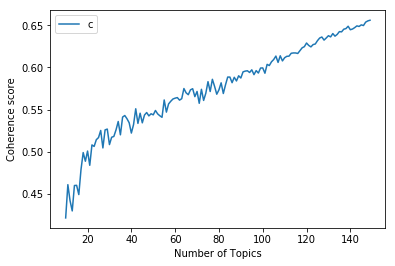

In [71]:
"""start=10
stop=150
step=1
model_list, coherence_values = compute_coherence_values(FIErrors_Msg_Dict, FIErrors_Msg_Txt_corpus,list(FIErrors["Msg_Txt"]), stop, start, step)
# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()"""

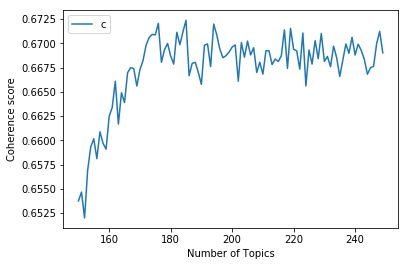

In [72]:
"""start=150
stop=250
step=1
model_list, coherence_values = compute_coherence_values(FIErrors_Msg_Dict, FIErrors_Msg_Txt_corpus,list(FIErrors["Msg_Txt"]), stop, start, step)
# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()"""

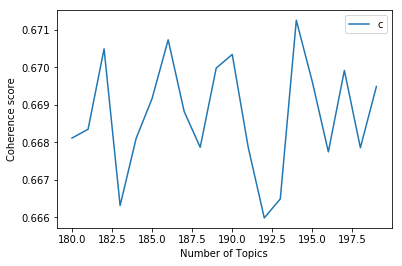

In [73]:
"""start=180
stop=200
step=1
model_list, coherence_values = compute_coherence_values(FIErrors_Msg_Dict, FIErrors_Msg_Txt_corpus,list(FIErrors["Msg_Txt"]), stop, start, step)
# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()"""

In [16]:
tfidfindex = similarities.SparseMatrixSimilarity(FIErrors_Msg_Txt_corpus, num_features=200)

In [17]:
lsi = models.LsiModel(FIErrors_Msg_Txt_CorpusTFIDF, id2word=FIErrors_Msg_Dict, num_topics=194)

In [18]:
corpus_lsi = lsi[FIErrors_Msg_Txt_CorpusTFIDF]

In [54]:
#lsi.print_topics(194)

In [26]:
index = similarities.MatrixSimilarity(lsi[FIErrors_Msg_Txt_corpus])

In [78]:
vec_bow=FIErrors_Msg_Dict.doc2bow(FIErrors["Msg_Txt"][0])

In [23]:
FIErrors["Msg_Txt"][0]

['config', 'substitution', 'account', 'account', 'company', 'code', 'missing']

In [79]:
vec_lsi = lsi[vec_bow]

In [81]:
sims = index[vec_lsi]  # perform a similarity query against the corpus
print(list(enumerate(sims)))

[(0, 1.0), (1, 0.2534901), (2, 1.8626451e-09), (3, -3.7252903e-09), (4, -1.3038516e-08), (5, -3.9115548e-08), (6, 0.10108012), (7, -3.7252903e-09), (8, 0.10572384), (9, 1.1175871e-08), (10, -2.2351742e-08), (11, 0.33413497), (12, 0.2723423), (13, -7.450581e-09), (14, 0.3333334), (15, -1.4901161e-08), (16, 0.0), (17, 0.0), (18, -7.450581e-09), (19, 0.19245008), (20, -1.4901161e-08), (21, 7.450581e-09), (22, 2.9802322e-08), (23, 0.16666666), (24, 5.5879354e-09), (25, 3.7252903e-09), (26, 0.14909095), (27, 0.11785114), (28, 0.33359057), (29, 0.54575527), (30, 0.2982394), (31, 7.450581e-09), (32, -2.3283064e-10), (33, -3.7252903e-09), (34, 0.22400993), (35, -3.7252903e-09), (36, 0.75592905), (37, 1.4901161e-08), (38, 4.4703484e-08), (39, 0.29901436), (40, -5.5879354e-09), (41, 1.6763806e-08), (42, 0.54433095), (43, -1.6763806e-08), (44, 0.0), (45, 5.5879354e-09), (46, 1.4901161e-08), (47, -8.8475645e-09), (48, -3.7252903e-08), (49, -6.519258e-09), (50, -7.450581e-09), (51, 3.7252903e-09), 

In [60]:
FIErrors["vec_bow"]=FIErrors["Msg_Txt"].apply(lambda x:FIErrors_Msg_Dict.doc2bow(x))
#FIErrors_Msg_Dict

In [66]:
#FIErrors.head()

In [67]:
FIErrors["vec_lsi"]=FIErrors["vec_bow"].apply(lambda x:lsi[x])

In [68]:
FIErrors["sims"]=FIErrors["vec_lsi"].apply(lambda x : index[x])

In [ ]:
lsi_vec[]

In [105]:
FIErrors["Category"]=0

In [106]:
b=1
for sims in FIErrors["sims"]:  # perform a similarity query against the corpus
    #b=0
    #c=0
    for a in enumerate(sims):
        if a[1]>0.8 and FIErrors["Category"][a[0]]==0 :
            FIErrors["Category"][a[0]]=b
    b=max(FIErrors["Category"])+1   #print(list(enumerate(sims)))

C:\D\Installations\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [109]:
FIErrors[["Message text","Category"]]

Message text  \
0                                                                Config. of substitution account for account ** in company code ** missing   
1                                                                     Document ** Company Code ** Fiscal Year ** has the following errors:   
2                                                                                         ** step ** failed for work package **; try again   
3                                                                                    Value ** of type ** in field '**' could not be mapped   
4                                                                                                   Debit/credit indicator is inconsistent   
5                                                                      Value ** of type ** in field '**' could not be mapped; see error **   
6                                                                 No code list configured for Type **, GDT **, List-ID ** and Bus. Sys. **   
7                                                                                                         Posting period ** ** is not open   
8                                                                Referenced document not yet posted (Comp.Code **, F.Year **, Document **)   
9                                                                       Referenced invoice not yet posted (CC **, FY **, Doc. **, Item **)   
10                                                                           Enter rate ** / ** rate type ** for ** in the system settings   
11                                                                                        Account ** requires an assignment to a CO object   
12                                                                                   G/L account ** is not defined in chart of accounts **   
13                                                                       Characteristic value ** does not exist for characteristic ** (**)   
14                                                                                             Vendor ** is not defined in company code **   
15                                                                                                                 Order ** does not exist   
16                                                                                                           Cost object ** does not exist   
17                                                                                                     Cost object ** does not exist on **   
18                                                                          Inbound mapping failed for **, value **, list ID **, agency **   
19                                                                                                           Reason code ** is not defined   
20                                                                                       Special G/L indicator ** not defined or incorrect   
21                                                                                                        Planning level ** does not exist   
22                                                                                         Vendor ** has no bank details with indicator **   
23                                                                                                  Tax code ** in procedure ** is invalid   
24                                                                Cost element ** in CO area ** for ** cannot be posted with primary costs   
25                                                                            Level ** does not belong to cash position (source symbol **)   
26                                                                        Jurisdiction code ** is not defined for calculation procedure **   
27                                                                            System error in routine ** error code ** function builder **   
28      

In [ ]:
FIErrors

In [107]:
len(FIErrors["Category"].unique())

157

In [108]:
max(FIErrors["Category"])

157

In [110]:
FIErrors.to_csv("FIErrors.csv",sep=',',encoding='utf-8',index=False)

In [88]:
b=0
c=0
for a in enumerate(sims):
    if a[1]>0.8:
        print(a[0])
b=b+1
print(b)

0
53
107
130
1


In [33]:
FIErrors["Message text"][0]

'Config. of substitution account for account ** in company code ** missing'

In [34]:
FIErrors["Message text"][53]

'Config. of substitution account for account ** in company code ** missing'

In [35]:
FIErrors["Message text"][107]

'Config. of substitution account for account &1 in company code &2 missing'

In [36]:
FIErrors["Message text"][130]

'Config. of substitution account for account x in <company code> missing'

In [37]:
FIErrors["Category"]=0

In [39]:
for sims in FIErrors["sims"]:  # perform a similarity query against the corpus
    for a in enumerate(sims):
        b=0
        c=0
        if a[1]>0.8:
            FIErrors["Category"][a[0]]=b
        b=b+1   #print(list(enumerate(sims)))

C:\D\Installations\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
len(FIErrors["Category"].unique())

213

In [ ]:
for a in range(len(FIErrors_Msg_Txt_corpus)):
    if 

In [16]:
FIErrors_Msg_Txt_tfidf[FIErrors_Msg_Txt_corpus[0]]

[(0, 0.3716589388020366),
 (1, 0.18334474264388104),
 (2, 0.22646777533379586),
 (3, 0.5382695930978133),
 (4, 0.44440789324828966),
 (5, 0.5382695930978133)]

In [18]:
type(tfidfindex)

gensim.similarities.docsim.SparseMatrixSimilarity

In [77]:
for a in enumerate(sims):
    b=0
    if a[1]>0.5:
        #print(a)
        b=b+1
    print(b)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1


In [39]:
from gensim.models import Word2Vec

In [40]:
model = Word2Vec(COErrors["Msg_Txt"], min_count=1)
# summarize the loaded model
print(model)

Word2Vec(vocab=110, size=100, alpha=0.025)


In [41]:
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

['Cost', 'center', 'XXXX', 'invalid', 'Value', '10006684', 'type', 'Center', 'ID', 'ERP', 'field', 'mapped', 'Partner', 'CCtr', 'Document', 'reversed', 'CO', 'doc', '319431291', '1000', 'found', 'Object', 'HP', 'supported', 'Account', 'XXXXXX', 'Assignment', 'object', 'XXXXXXXX', 'No', 'information', 'Authorization', 'Error', 'Doc', 'Controlling', 'Area', 'exist', 'WBS', 'element', '1', 'doesn', 't', 'CJ', '021', 'requires', 'assignment', 'KI', '235', 'System', 'FINS', '2', 'ACDOC', '001', 'UNIT', 'error', 'Create', 'master', 'record', 'KL', 'Specify', 'internal', 'interval', 'UOM', 'related', 'Preceeding', 'document', 'missing', 'CFIN', 'ADD', 'incomplete', 'Order', 'order', 'carry', 'revenues', 'Operating', 'concern', 'Number', 'operating', 'number', 'currently', 'locked', 'Wait', 'moment', 'try', 'blocked', 'direct', 'postings', 'on', 'Date', 'Do', 'assign', 'objects', 'cost', 'accounting', 'account', 'Version', '0', 'defined', 'fiscal', 'year', '2014', 'revenue', 'date', 'controlli

In [44]:
# access vector for one word
print(model['Operating'])
type(model['Operating'])

model['Operating'].shape

[-1.3732924e-03 -1.7826369e-03 -2.1721078e-03  2.8302898e-03
  4.3214727e-03 -3.3168935e-03 -1.6204540e-03  3.8406777e-03
 -4.0197284e-03 -9.0544723e-04  2.2670485e-03 -3.4857690e-03
  3.5869875e-03  3.9743851e-03  2.5478599e-05  2.9816974e-03
 -1.2709406e-05 -1.1923430e-04 -2.3034656e-04  3.1535586e-05
 -4.8528928e-03  2.8201665e-03  1.9540952e-03 -1.1421525e-03
 -9.0812537e-04 -3.5193381e-03  7.6520824e-05 -1.3808976e-03
 -9.3310978e-04  1.8253624e-03  1.2433627e-03 -6.9364127e-05
 -2.5712133e-03 -2.3705766e-03 -3.6216343e-03  3.0648422e-03
 -1.1957939e-03  2.5710699e-03  2.1907801e-03 -1.3136640e-03
  7.3085102e-04 -1.9240721e-04 -3.3953073e-03  4.6498288e-04
  2.1969518e-03  1.5485723e-03 -2.4992812e-03  1.5793890e-03
 -3.2825565e-03  2.2480297e-03 -2.0365058e-03  7.2927820e-04
  3.2420611e-04  2.4777135e-05  4.0006195e-03  5.2539277e-04
  6.6105806e-04  2.8895719e-03  2.7800933e-03 -2.4537132e-03
 -1.6168722e-04 -2.1022642e-03 -4.6224319e-03 -1.3225182e-04
 -4.7255694e-03 -2.30935

C:\D\Installations\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\D\Installations\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\D\Installations\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(100,)

In [ ]:
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

# Home 

In [8]:
FIErrors=pd.read_csv("FIErrors.csv")

In [9]:
FIErrors[['Message text','Message class','Category']]

Message text  \
0                                                                Config. of substitution account for account ** in company code ** missing   
1                                                                     Document ** Company Code ** Fiscal Year ** has the following errors:   
2                                                                                         ** step ** failed for work package **; try again   
3                                                                                    Value ** of type ** in field '**' could not be mapped   
4                                                                                                   Debit/credit indicator is inconsistent   
5                                                                      Value ** of type ** in field '**' could not be mapped; see error **   
6                                                                 No code list configured for Type **, GDT **, List-ID ** and Bus. Sys. **   
7                                                                                                         Posting period ** ** is not open   
8                                                                Referenced document not yet posted (Comp.Code **, F.Year **, Document **)   
9                                                                       Referenced invoice not yet posted (CC **, FY **, Doc. **, Item **)   
10                                                                           Enter rate ** / ** rate type ** for ** in the system settings   
11                                                                                        Account ** requires an assignment to a CO object   
12                                                                                   G/L account ** is not defined in chart of accounts **   
13                                                                       Characteristic value ** does not exist for characteristic ** (**)   
14                                                                                             Vendor ** is not defined in company code **   
15                                                                                                                 Order ** does not exist   
16                                                                                                           Cost object ** does not exist   
17                                                                                                     Cost object ** does not exist on **   
18                                                                          Inbound mapping failed for **, value **, list ID **, agency **   
19                                                                                                           Reason code ** is not defined   
20                                                                                       Special G/L indicator ** not defined or incorrect   
21                                                                                                        Planning level ** does not exist   
22                                                                                         Vendor ** has no bank details with indicator **   
23                                                                                                  Tax code ** in procedure ** is invalid   
24                                                                Cost element ** in CO area ** for ** cannot be posted with primary costs   
25                                                                            Level ** does not belong to cash position (source symbol **)   
26                                                                        Jurisdiction code ** is not defined for calculation procedure **   
27                                                                            System error in routine ** error code ** function builder **   
28      

In [31]:
data=FIErrors[["Message class","Message text","Resolution","Engie","Mars","Lufthansa","Daimler","Category"]]

In [41]:
data2=data.groupby(['Message class','Category'])
data1=data.groupby(['Message class',])

In [42]:
dflist=[]
for key,item in data1:
    dflist.append(data1.get_group(key))

In [16]:
dflist[10]

Message class                       Message text  \
188          BF00  Bank <bank number> does not exist   

                                                                                                  Resolution  \
188  Make sure Bank information (BSEC-BANKN, BANKL, BANKS, IBAN) is cleared in CPD vendor/customer position.   

     Category  
188       144

In [62]:
dflist[10]['Category'].count()

2

In [60]:
result=pd.concat(dflist)

In [86]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 16), dpi=80, facecolor='w', edgecolor='k')

In [88]:
plt.figure(figsize=(20,16))

In [24]:
result.sort_values(by='Message class').reset_index(drop=True)

Message class  \
0                    [bf00]   
1                      [bk]   
2                      [bp]   
3                      [bs]   
4                      [cn]   
5               [deftax_mx]   
6                       [e]   
7                      [f2]   
8                      [f2]   
9                      [f2]   
10                     [f4]   
11                     [f5]   
12                     [f5]   
13                     [f5]   
14                     [f5]   
15                     [f5]   
16                     [f5]   
17                     [f5]   
18                     [f5]   
19                     [f5]   
20                     [f5]   
21                     [f5]   
22                     [f5]   
23                     [f5]   
24                     [f5]   
25                     [f5]   
26                     [f5]   
27                     [f5]   
28                     [f5]   
29                     [f5]   
30                     [f5]   
31                     [f5]   
32                     [f5]   
33                     [f5]   
34                     [f5]   
35                     [f5]   
36                     [f5]   
37                     [f5]   
38                     [f5]   
39                     [f5]   
40                     [f5]   
41                     [f5]   
42                     [f5]   
43                     [f5]   
44                     [f5]   
45                     [f5]   
46                     [f5]   
47                     [f5]   
48                     [f5]   
49                     [f5]   
50                     [f5]   
51                     [f5]   
52                     [f5]   
53                     [f5]   
54                     [f5]   
55                     [f5]   
56                     [f5]   
57                     [f5]   
58                     [f5]   
59                     [f5]   
60                     [f5]   
61                     [f5]   
62                     [f5]   
63                     [f5]   
64                     [f5]   
65                     [f5]   
66                     [f5]   
67                     [f5]   
68                     [f5]   
69                     [f5]   
70                     [f5]   
71                    [f5a]   
72                    [f5a]   
73               [faa_post]   
74       [fagl_ledger_cust]   
75                     [fb]   
76                     [ff]   
77                     [ff]   
78                     [ff]   
79                     [ff]   
80                     [ff]   
81                     [ff]   
82                     [ff]   
83                     [ff]   
84                     [ff]   
85                     [ff]   
86                     [ff]   
87                     [ff]   
88                     [ff]   
89                     [ff]   
90                     [ff]   
91                     [ff]   
92                     [fh]   
93                     [fh]   
94                     [fi]   
95                     [fi]   
96                 [ficore]   
97                 [ficore]   
98        [fins_acdoc_cust]   
99        [fins_acdoc_cust]   
100       [fins_acdoc_post]   
101      [fins_cfin_ac_doc]   
102      [fins_cfin_ac_doc]   
103      [fins_cfin_ac_doc]   
104      [fins_cfin_ac_doc]   
105      [fins_cfin_ac_doc]   
106      [fins_cfin_ac_doc]   
107      [fins_cfin_ac_doc]   
108      [fins_cfin_ac_doc]   
109      [fins_cfin_ac_doc]   
110      [fins_cfin_ac_doc]   
111      [fins_cfin_ac_doc]   
112      [fins_cfin_ac_doc]   
113      [fins_cfin_ac_doc]   
114      [fins_cfin_ac_doc]   
115      [fins_cfin_ac_doc]   
116      [fins_cfin_ac_doc]   
117      [fins_cfin_ac_doc]   
118      [fins_cfin_ac_doc]   
119      [fins_cfin_ac_doc]   
120      [fins_cfin_ac_doc]   
121      [fins_cfin_ac_doc]   
122      [fins_cfin_ac_doc]   
123      [fins_cfin_ac_doc]   
124      [fins_cfin_ac_doc]   
125      [fins_cfin_ac_doc]   
126      [fins_cfin_ac_doc]   
127      [fins_cfin_ac_doc]   
128      [fins_

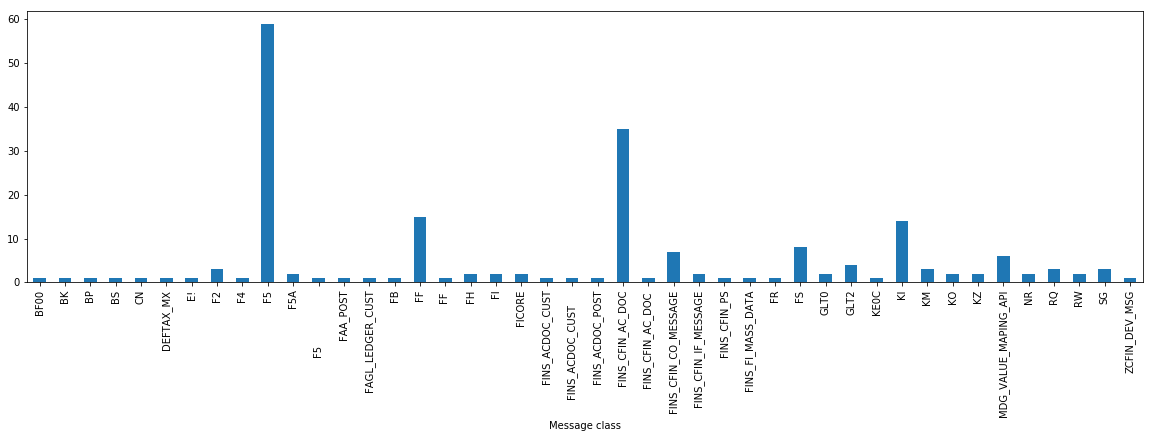

In [94]:
result.groupby('Message class')['Category'].count().plot(kind='bar',figsize=(20,5))

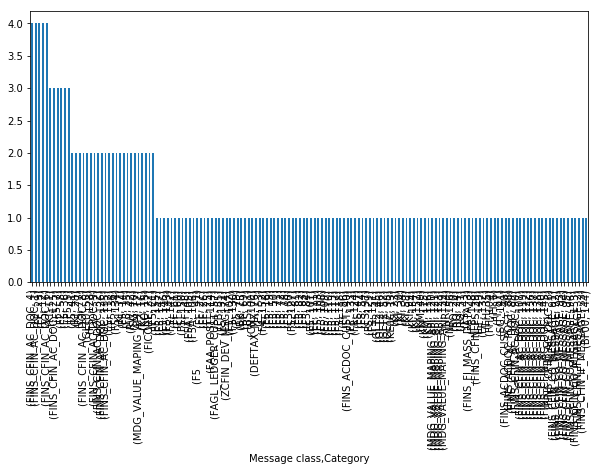

In [130]:
result.groupby(['Message class','Category'])['Message text'].count().sort_values(ascending=False).plot(kind='bar',figsize=(10,5))

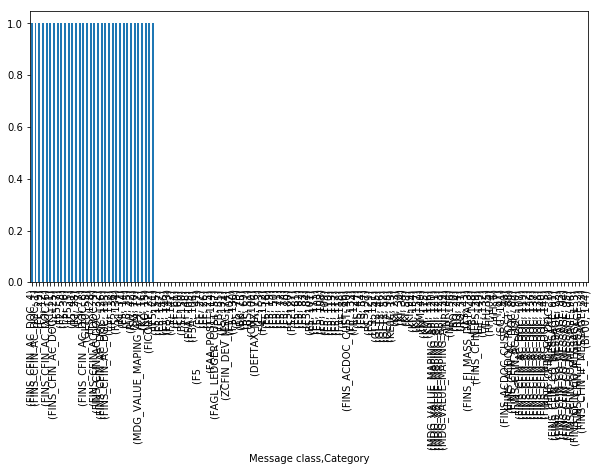

In [139]:
result.groupby(['Message class','Category'])['Message text'].count().sort_values(ascending=False).plot(kind='bar',figsize=(10,5))

In [148]:
(result.groupby(['Message class','Category'])['Category'].count().sort_values(ascending=False))

Message class         Category
FINS_CFIN_AC_DOC      4           4
                      1           4
FF                    29          4
F5                    12          4
FINS_CFIN_AC_DOC      6           4
KI                    11          3
FINS_CFIN_AC_DOC      125         3
F5                    7           3
F2                    58          3
F5                    36          3
                      5           3
                      41          2
KI                    28          2
F5                    77          2
FINS_CFIN_AC_DOC      8           2
GLT0                  55          2
FS                    128         2
FINS_CFIN_AC_DOC      9           2
                      32          2
                      126         2
                      135         2
F5                    112         2
                      38          2
                      134         2
KI                    37          2
F5                    14          2
                      35         

In [175]:
len(result.groupby(['Message class'])['Category'].groups['F5'].unique())

59

In [263]:
max(result["Category"])

157

In [138]:
(result.groupby(['Message class','Category'])['Message text'].count().sort_values(ascending=False)).index[0][0]

'FINS_CFIN_AC_DOC'

In [185]:
result[(result['Message class']=='F5') & (result['Mars']==1)]

Message class  \
4             F5   
7             F5   
12            F5   
14            F5   
19            F5   
20            F5   
22            F5   
36            F5   
37            F5   
39            F5   

                                                     Message text  \
4                          Debit/credit indicator is inconsistent   
7                                Posting period ** ** is not open   
12          G/L account ** is not defined in chart of accounts **   
14                    Vendor ** is not defined in company code **   
19                                  Reason code ** is not defined   
20              Special G/L indicator ** not defined or incorrect   
22                Vendor ** has no bank details with indicator **   
36  Account ** in company code ** is not a reconciliation account   
37                             No alternative payer/payee defined   
39     Reconciliation account ** or short key ** is not permitted   

                                                                                                                                                                          Resolution  \
4   OSS Note 2535203 to be implemented in the Source system & perform extraction again & then execute the FI initial load. So that the autocleared documents are not extracted again   
7                                                                                                                                                        Need to open posting period   
12                                                                                                                                                   G/L account needs to be created   
14                                                                                                                                     Related to Error F5 846, hence Not applicable   
19                                                                                                                        Mapping action "to be cleared" maintained for Reason codes   
20                                                                                                                          Mapping action"to be cleared" to Special G/L indicator     
22                                                  Bank keys maintained in Target for few documents that were relevant for O/H postings\r\nOr clear BSEG-BVTYP in "Mapping Actions"   
36                                                                                                                                                               GL Mapping changed    
37                                                                                                              One Time Vendor created and mapping Changed to complete the postings   
39                                                                                                     Alternative reconcilition accounts configuration updated in the Target system   

    Engie  Mars  Lufthansa  Daimler  Category  
4       0     1          0        0         5  
7       0     1          0        0         7  
12      0     1          0        0        12  
14      0     1          0        0        14  
19      0     1          0        0        18  
20      0     1          0        0        19  
22      0     1          0        0        21  
36      0     1          0        0        35  
37      0     1          0        0        36  
39      0     1          0        0        38

In [186]:
result[(result['Message class']=='F5') & (result['Engie']==1)]

Message class  \
51             F5   
62             F5   
77             F5   
78             F5   
83             F5   
84             F5   
85             F5   
86             F5   
87             F5   
88             F5   
89             F5   
90             F5   
91             F5   
92             F5   
93             F5   
94             F5   
122            F5   
123            F5   
124            F5   

                                                                  Message text  \
51                       Tax does not equal 0 when tax percentage rate is zero   
62                                      Debit/credit indicator is inconsistent   
77                                       Customer not extended to company code   
78                                         Vendor Not extended to Company Code   
83   No special G/L acct defined for acct type &1 sp.G/L ind. &2 recon.acct &3   
84                                   The entry &2 &3 &4 is missing in table &1   
85                                     Complete withholding tax amount details   
86                                            Posting period &1 &2 is not open   
87                           Account type & is not defined for document type &   
88                            G/L account &1 is not defined in company code &2   
89                       G/L account &1 is not defined in chart of accounts &2   
90                                       Maximum number of items in FI reached   
91     No accts maintained for company code clearing between comp.cds & and &.   
92                                          No alternative payer/payee defined   
93                                            Text for posting key & not found   
94                                             Dunning block &1 is not defined   
122          Exchange rate diff.accts are not defined for account & currency &   
123                     Special G/L posting to one-time account is not defined   
124     Postings to account & (company code &) are only possible in currency &   

                                                                                                                                                                                                              Resolution  \
51                                             Check the source and target tax code both should have the 0 rates and mapping should be correct if no then we will have to make this message as a warning message in OBA5   
62                                                                                          OSS message an SAP note (2370448) was implemented as attached by Martins for INEO roll out, however the error still persist.   
77        Download the List of BP in error,fetch the Identification number for these BP from BUT0ID, check if this ID is present in the input fiel form PWC, if yes carry out the extension using BP  automation program   
78        Download the List of BP in error,fetch the Identification number for these BP from BUT0ID, check if this ID is present in the input fiel form PWC, if yes carry out the extension using BP  automation program   
83                                                                                                                                                         GL account is not maintain in spl gl configuration Tcode FBKP   
84   There are 2 resolution on this.\r\n1. Maintain the mapping action as 'Clear Data' for Withholding tax code.\r\n2. Maintain Substitution to clear the Withholding tax code in that perticular document using Set ID.   
85   There are 2 resolution on this.\r\n1. Maintain the mapping action as 'Clear Data' for Withholding tax code.\r\n2. Maintain Substitution to clear the Withholding tax code in that perticular document using Set ID.   
86                                                                                                          Activate Rule 12 in ZCFIN_AC_Rule table & Maintain the variable ZCFIN_BUKR

In [187]:
result[(result['Message class']=='F5') & (result['Lufthansa']==1)]

Message class  \
128            F5   
133            F5   
134            F5   
135            F5   
136            F5   
138            F5   
139            F5   
140            F5   
144            F5   
145            F5   
154            F5   
155            F5   
156            F5   
160            F5   
161            F5   
163            F5   
167            F5   
168            F5   
175            F5   
176            F5   
182            F5   
186            F5   
187            F5   
190            F5   
193            F5   
196            F5   
197            F5   
200            F5   
206            F5   
208            F5   

                                                                                 Message text  \
128     No special G/L acct defined for acct type D sp.G/L ind. E recon.acct <account number>   
133                                       Enter a name and city for one-time account postings   
134                               Item specified for invoice reference is not an invoice item   
135                                                        No alternative payer/payee defined   
136                                                         Inconsistent currency information   
138                                                    Debit/credit indicator is inconsistent   
139                G/L Account <account> ist not defined in Chart of Account Chart of Account   
140                                       Relationship between branch/head office has changed   
144                            Account type/account for invoice reference does not match item   
145                                                           Balance in transaction currency   
154                Consolidated companies <company code 1> and <company code 2> are different   
155                      Vendor <vendor number> is not defined in company code <company code>   
156                                     Posting period <posting period ID> <year> is not open   
160     Account  <account number> in company code <company code> cannot be directly posted to   
161                                                                        Enter bank country   
163     G/L account  <account number> is not defined in chart of accounts <chart of accounts>   
167      Field <field> is a required field for G/L account <account number> in <company code>   
168      Field <field> is a required field for G/L account <account number> in <company code>   
175     G/L account  <account number> is not defined in chart of accounts <chart of accounts>   
176                G/L Account <account> ist not defined in Chart of Account Chart of Account   
182                       Vendor <vendor number> has no bank details with indicator <bank ID>   
186                     Company code <company code> is not set up for the payment transaction   
187             House bank <bank id> is not defined in the paying company code <company code>   
190  Account  <account number> in company code <company code> is not a reconciliation account   
193         Reconciliation account <account number> or short key <short key> is not permitted   
196                  Posting keys for account determination for transaction YYY do not exist    
197                                                            Payment term XXXX not defined    
200                                        For payment term X the day limit Y is not defined    
206                                            G/L account x is not defined in company code y   
208                                                        Account x y is blocked for posting   

                                                                                                                                                                                                                                                                                                                                                        

In [188]:
result[(result['Message class']=='F5') & (result['Daimler']==1)]

Message class  \
154            F5   
155            F5   
156            F5   
160            F5   
161            F5   
163            F5   
167            F5   
168            F5   
175            F5   
176            F5   
182            F5   
186            F5   
187            F5   
190            F5   
193            F5   
196            F5   
197            F5   
200            F5   
206            F5   
208            F5   

                                                                                 Message text  \
154                Consolidated companies <company code 1> and <company code 2> are different   
155                      Vendor <vendor number> is not defined in company code <company code>   
156                                     Posting period <posting period ID> <year> is not open   
160     Account  <account number> in company code <company code> cannot be directly posted to   
161                                                                        Enter bank country   
163     G/L account  <account number> is not defined in chart of accounts <chart of accounts>   
167      Field <field> is a required field for G/L account <account number> in <company code>   
168      Field <field> is a required field for G/L account <account number> in <company code>   
175     G/L account  <account number> is not defined in chart of accounts <chart of accounts>   
176                G/L Account <account> ist not defined in Chart of Account Chart of Account   
182                       Vendor <vendor number> has no bank details with indicator <bank ID>   
186                     Company code <company code> is not set up for the payment transaction   
187             House bank <bank id> is not defined in the paying company code <company code>   
190  Account  <account number> in company code <company code> is not a reconciliation account   
193         Reconciliation account <account number> or short key <short key> is not permitted   
196                  Posting keys for account determination for transaction YYY do not exist    
197                                                            Payment term XXXX not defined    
200                                        For payment term X the day limit Y is not defined    
206                                            G/L account x is not defined in company code y   
208                                                        Account x y is blocked for posting   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Resolution  \
154                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                In T-Code OBA7, for Document Type XX "CFIN Replication", make sure that the Flag for "Inter-Company postings” (section Control Data) is set.   
155                                                                                                           

In [192]:
result[result['Engie']==1]

Message class  \
81                     BK   
75                     BP   
52                     BS   
121                    CN   
82              DEFTAX_MX   
56                     E!   
61                     F2   
51                     F5   
62                     F5   
77                     F5   
78                     F5   
83                     F5   
84                     F5   
85                     F5   
86                     F5   
87                     F5   
88                     F5   
89                     F5   
90                     F5   
91                     F5   
92                     F5   
93                     F5   
94                     F5   
122                    F5   
123                    F5   
124                    F5   
60       FAGL_LEDGER_CUST   
95                     FB   
49                     FF   
64                     FF   
67                     FF   
96                     FF   
97                     FF   
125                    FH   
65                     FI   
98                     FI   
99        FINS_ACDOC_POST   
5        FINS_CFIN_AC_DOC   
6        FINS_CFIN_AC_DOC   
33       FINS_CFIN_AC_DOC   
53       FINS_CFIN_AC_DOC   
66       FINS_CFIN_AC_DOC   
100      FINS_CFIN_AC_DOC   
101      FINS_CFIN_AC_DOC   
102      FINS_CFIN_AC_DOC   
103      FINS_CFIN_AC_DOC   
104      FINS_CFIN_AC_DOC   
105      FINS_CFIN_AC_DOC   
106      FINS_CFIN_AC_DOC   
107      FINS_CFIN_AC_DOC   
108  FINS_CFIN_CO_MESSAGE   
109  FINS_CFIN_CO_MESSAGE   
110  FINS_CFIN_CO_MESSAGE   
111  FINS_CFIN_CO_MESSAGE   
112  FINS_CFIN_CO_MESSAGE   
113  FINS_CFIN_CO_MESSAGE   
44                     FS   
48                     FS   
57                     FS   
114                    FS   
58                   GLT0   
126                  GLT0   
46                   GLT2   
47                   GLT2   
54                   GLT2   
115                  GLT2   
55                     KI   
63                     KI   
116                    KI   
117                    KI   
118                    KI   
50                     KM   
119                    KO   
16                     KZ   
120  MDG_VALUE_MAPING_API   
45                     NR   
127                    SG   
80          ZCFIN_DEV_MSG   

                                                                  Message text  \
81                            Assign a number range to business transaction &.   
75                                                       Bank Details missing    
52                                             System status ** is active (**)   
121                           WBS element &1 has different inventory valuation   
82   Deferred tax: Do not post invoice &1 with both acquisition and other taxe   
56                       Currency "**" is expiring; from **, use currency "**"   
61                                             Payment block ** is not defined   
51                       Tax does not equal 0 when tax percentage rate is zero   
62                                      Debit/credit indicator is inconsistent   
77                                       Customer not extended to company code   
78                                         Vendor Not extended to Company Code   
83   No special G/L acct defined for acct type &1 sp.G/L ind. &2 recon.acct &3   
84                                   The entry &2 &3 &4 is missing in table &1   
85                                     Complete withholding tax amount details   
86                                            Posting period &1 &2 is not open   
87                           Account type & is not defined for document type &   
88                            G/L account &1 is not defined in company code &2   
89                       G/L account &1 is not defined in chart of accounts &2   
90                                       Maximum number of items in FI reached   
91     No accts maintained for company code clearing between comp.cds & and &.  

In [191]:
result[result['Mars']==1]

Message class  \
4                     F5   
7                     F5   
12                    F5   
14                    F5   
19                    F5   
20                    F5   
22                    F5   
36                    F5   
37                    F5   
39                    F5   
42  F5                     
26                    FF   
27                    FF   
28                    FF   
30                    FF   
23                FICORE   
41  FINS_ACDOC_CUST        
0       FINS_CFIN_AC_DOC   
3       FINS_CFIN_AC_DOC   
5       FINS_CFIN_AC_DOC   
6       FINS_CFIN_AC_DOC   
8       FINS_CFIN_AC_DOC   
9       FINS_CFIN_AC_DOC   
33      FINS_CFIN_AC_DOC   
1   FINS_CFIN_IF_MESSAGE   
34  FINS_CFIN_IF_MESSAGE   
40          FINS_CFIN_PS   
2      FINS_FI_MASS_DATA   
58                  GLT0   
13                  KE0C   
11                    KI   
24                    KI   
29                    KI   
31                    KI   
35                    KI   
38                    KI   
15                    KO   
16                    KZ   
17                    KZ   
18  MDG_VALUE_MAPING_API   
21                    RQ   
25                    RQ   
32                    RQ   
43                    RW   
10                    SG   
80         ZCFIN_DEV_MSG   

                                                                 Message text  \
4                                      Debit/credit indicator is inconsistent   
7                                            Posting period ** ** is not open   
12                      G/L account ** is not defined in chart of accounts **   
14                                Vendor ** is not defined in company code **   
19                                              Reason code ** is not defined   
20                          Special G/L indicator ** not defined or incorrect   
22                            Vendor ** has no bank details with indicator **   
36              Account ** in company code ** is not a reconciliation account   
37                                         No alternative payer/payee defined   
39                 Reconciliation account ** or short key ** is not permitted   
42  G/L account ** is not defined in company code **                            
26           Jurisdiction code ** is not defined for calculation procedure **   
27               System error in routine ** error code ** function builder **   
28              Company code ** requires you to enter a tax jurisdiction code   
30                      Error in account determination: table ** key ** ** **   
23                                     Tax code ** in procedure ** is invalid   
41  Default values for postings in Controlling not defined for CoCode **        
0   Config. of substitution account for account ** in company code ** missing   
3                       Value ** of type ** in field '**' could not be mapped   
5         Value ** of type ** in field '**' could not be mapped; see error **   
6    No code list configured for Type **, GDT **, List-ID ** and Bus. Sys. **   
8   Referenced document not yet posted (Comp.Code **, F.Year **, Document **)   
9          Referenced invoice not yet posted (CC **, FY **, Doc. **, Item **)   
33              Internal representation for unit of measure ** does not exist   
1        Document ** Company Code ** Fiscal Year ** has the following errors:   
34                  Cross Company document with Cross-CC Number ** is missing   
40                                                   WBS element ** not found   
2                            ** step ** failed for work package **; try again   
58    Document splitting causes field overflow for currency type ** in row **   
13          Characteristic value ** does not exist for characteristic ** (**)   
11                           Account ** requires an assignment to a CO object   
24   Cost element ** in CO area ** for ** cannot be posted with primary costs   
29        The CO acco

In [190]:
result[result['Lufthansa']==1]

Message class  \
188                  BF00   
162                    F2   
191                    F2   
202                    F4   
128                    F5   
133                    F5   
134                    F5   
135                    F5   
136                    F5   
138                    F5   
139                    F5   
140                    F5   
144                    F5   
145                    F5   
154                    F5   
155                    F5   
156                    F5   
160                    F5   
161                    F5   
163                    F5   
167                    F5   
168                    F5   
175                    F5   
176                    F5   
182                    F5   
186                    F5   
187                    F5   
190                    F5   
193                    F5   
196                    F5   
197                    F5   
200                    F5   
206                    F5   
208                    F5   
129                   F5A   
131                   F5A   
141              FAA_POST   
137                    FF   
164                    FF   
166                    FF   
192                    FF   
198                    FF   
199                    FF   
165                   FF    
181                    FH   
204                FICORE   
203       FINS_ACDOC_CUST   
5        FINS_CFIN_AC_DOC   
6        FINS_CFIN_AC_DOC   
130      FINS_CFIN_AC_DOC   
132      FINS_CFIN_AC_DOC   
146      FINS_CFIN_AC_DOC   
149      FINS_CFIN_AC_DOC   
152      FINS_CFIN_AC_DOC   
153      FINS_CFIN_AC_DOC   
169      FINS_CFIN_AC_DOC   
170      FINS_CFIN_AC_DOC   
171      FINS_CFIN_AC_DOC   
172      FINS_CFIN_AC_DOC   
173      FINS_CFIN_AC_DOC   
174      FINS_CFIN_AC_DOC   
177      FINS_CFIN_AC_DOC   
178      FINS_CFIN_AC_DOC   
180      FINS_CFIN_AC_DOC   
183      FINS_CFIN_AC_DOC   
194      FINS_CFIN_AC_DOC   
195      FINS_CFIN_AC_DOC   
184     FINS_CFIN_AC_DOC    
205  FINS_CFIN_CO_MESSAGE   
151                    FR   
157                    FS   
158                    FS   
159                    FS   
201                    FS   
189                    KI   
207                    KI   
210                    KI   
142                    KM   
143                    KM   
147  MDG_VALUE_MAPING_API   
148  MDG_VALUE_MAPING_API   
150  MDG_VALUE_MAPING_API   
179  MDG_VALUE_MAPING_API   
209                    NR   
212                    RW   
185                    SG   

                                                                                                                              Message text  \
188                                                                                                      Bank <bank number> does not exist   
162                                                                                 Payment block <payment block indicator> is not defined   
191                                                                                 Payment block <payment block indicator> is not defined   
202                                                                                             Credit control area X has not been defined   
128                                                  No special G/L acct defined for acct type D sp.G/L ind. E recon.acct <account number>   
133                                                                                    Enter a name and city for one-time account postings   
134                                                                            Item specified for invoice reference is not an invoice item   
135                                                                                                     No alternative payer/payee defined   
136                                                                                                      Inconsistent currency information   
138                                                                 

In [189]:
result[result['Daimler']==1]

Message class  \
188                  BF00   
162                    F2   
191                    F2   
202                    F4   
154                    F5   
155                    F5   
156                    F5   
160                    F5   
161                    F5   
163                    F5   
167                    F5   
168                    F5   
175                    F5   
176                    F5   
182                    F5   
186                    F5   
187                    F5   
190                    F5   
193                    F5   
196                    F5   
197                    F5   
200                    F5   
206                    F5   
208                    F5   
164                    FF   
166                    FF   
192                    FF   
198                    FF   
199                    FF   
165                   FF    
181                    FH   
204                FICORE   
203       FINS_ACDOC_CUST   
5        FINS_CFIN_AC_DOC   
6        FINS_CFIN_AC_DOC   
33       FINS_CFIN_AC_DOC   
152      FINS_CFIN_AC_DOC   
153      FINS_CFIN_AC_DOC   
169      FINS_CFIN_AC_DOC   
170      FINS_CFIN_AC_DOC   
171      FINS_CFIN_AC_DOC   
172      FINS_CFIN_AC_DOC   
173      FINS_CFIN_AC_DOC   
174      FINS_CFIN_AC_DOC   
177      FINS_CFIN_AC_DOC   
178      FINS_CFIN_AC_DOC   
180      FINS_CFIN_AC_DOC   
183      FINS_CFIN_AC_DOC   
194      FINS_CFIN_AC_DOC   
195      FINS_CFIN_AC_DOC   
184     FINS_CFIN_AC_DOC    
205  FINS_CFIN_CO_MESSAGE   
151                    FR   
157                    FS   
158                    FS   
159                    FS   
201                    FS   
189                    KI   
207                    KI   
210                    KI   
179  MDG_VALUE_MAPING_API   
209                    NR   
212                    RW   
185                    SG   

                                                                                                 Message text  \
188                                                                         Bank <bank number> does not exist   
162                                                    Payment block <payment block indicator> is not defined   
191                                                    Payment block <payment block indicator> is not defined   
202                                                                Credit control area X has not been defined   
154                                Consolidated companies <company code 1> and <company code 2> are different   
155                                      Vendor <vendor number> is not defined in company code <company code>   
156                                                     Posting period <posting period ID> <year> is not open   
160                     Account  <account number> in company code <company code> cannot be directly posted to   
161                                                                                        Enter bank country   
163                     G/L account  <account number> is not defined in chart of accounts <chart of accounts>   
167                      Field <field> is a required field for G/L account <account number> in <company code>   
168                      Field <field> is a required field for G/L account <account number> in <company code>   
175                     G/L account  <account number> is not defined in chart of accounts <chart of accounts>   
176                                G/L Account <account> ist not defined in Chart of Account Chart of Account   
182                                       Vendor <vendor number> has no bank details with indicator <bank ID>   
186                                     Company code <company code> is not set up for the payment transaction   
187                             House bank <bank id> is not defined in the paying company code <company code>   
190                  Account  <account number> in company code <company code> is not a recon

E:\SoftwareInstallations\anaconda\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Message class
BF00                    AxesSubplot(0.125,0.125;0.775x0.755)
BK                      AxesSubplot(0.125,0.125;0.775x0.755)
BP                      AxesSubplot(0.125,0.125;0.775x0.755)
BS                      AxesSubplot(0.125,0.125;0.775x0.755)
CN                      AxesSubplot(0.125,0.125;0.775x0.755)
DEFTAX_MX               AxesSubplot(0.125,0.125;0.775x0.755)
E!                      AxesSubplot(0.125,0.125;0.775x0.755)
F2                      AxesSubplot(0.125,0.125;0.775x0.755)
F4                      AxesSubplot(0.125,0.125;0.775x0.755)
F5                      AxesSubplot(0.125,0.125;0.775x0.755)
F5A                     AxesSubplot(0.125,0.125;0.775x0.755)
F5                      AxesSubplot(0.125,0.125;0.775x0.755)
FAA_POST                AxesSubplot(0.125,0.125;0.775x0.755)
FAGL_LEDGER_CUST        AxesSubplot(0.125,0.125;0.775x0.755)
FB                      AxesSubplot(0.125,0.125;0.775x0.755)
FF                      AxesSubplot(0.125,0.125;0.775x0.755)
FF        

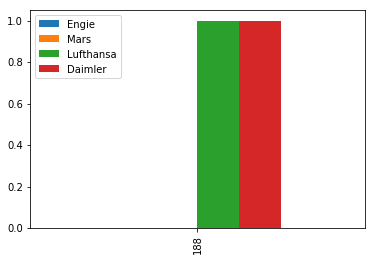

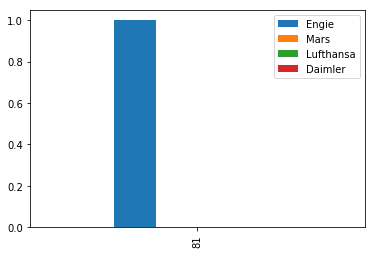

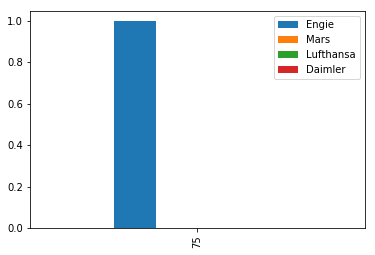

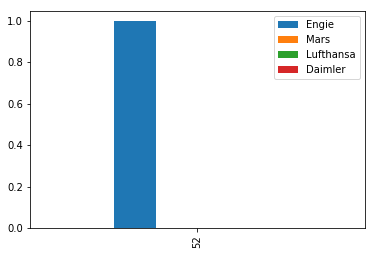

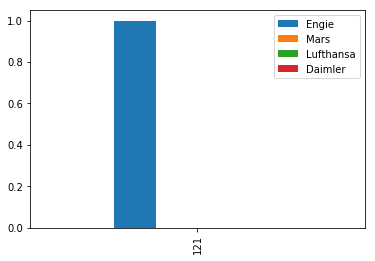

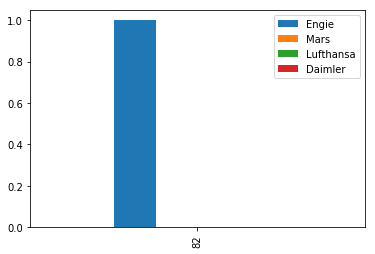

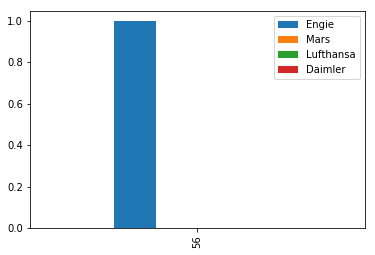

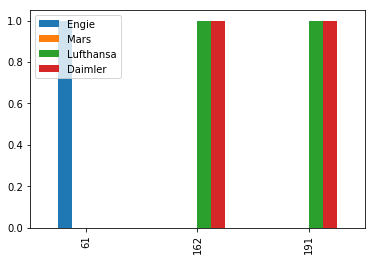

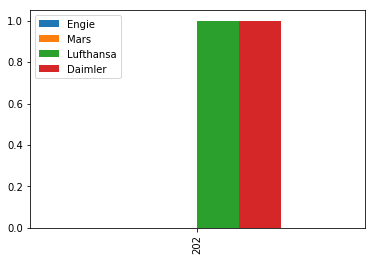

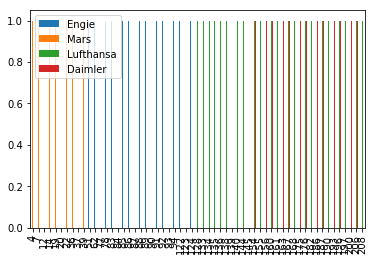

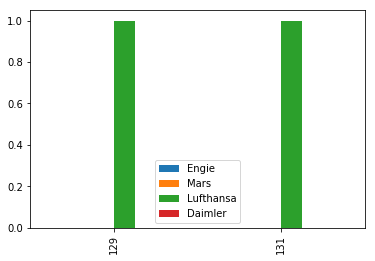

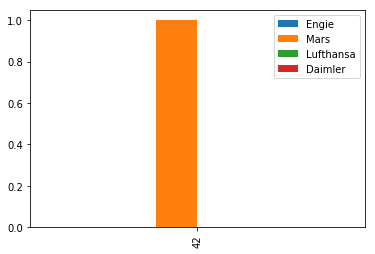

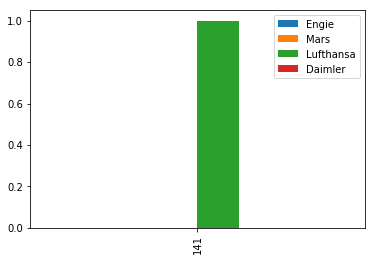

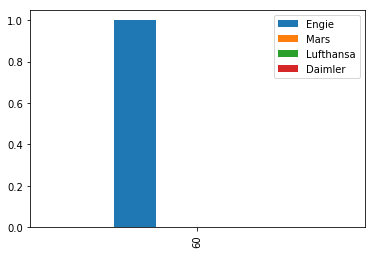

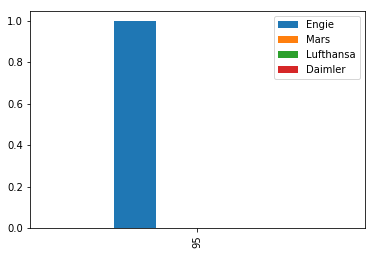

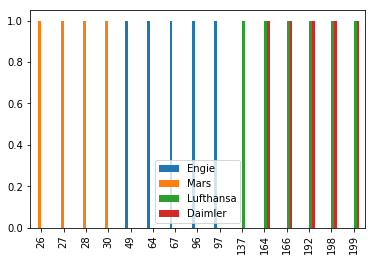

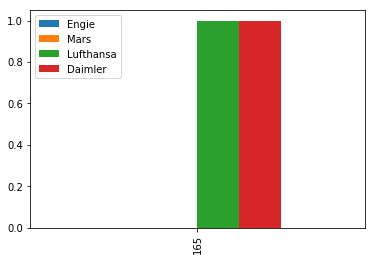

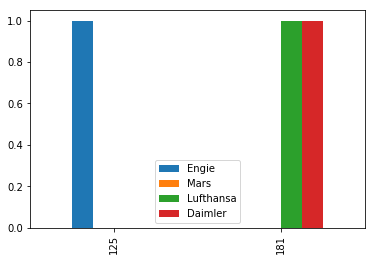

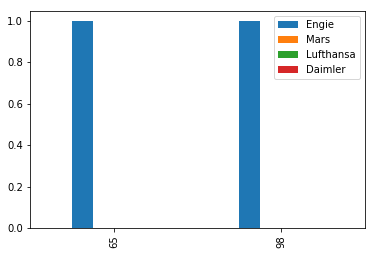

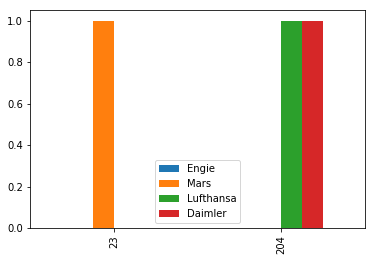

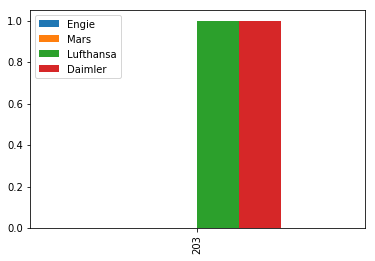

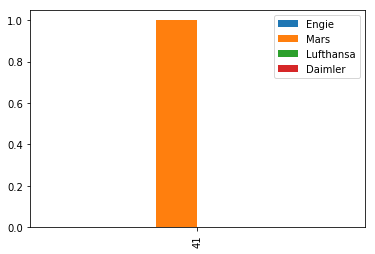

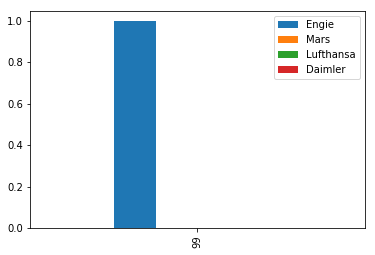

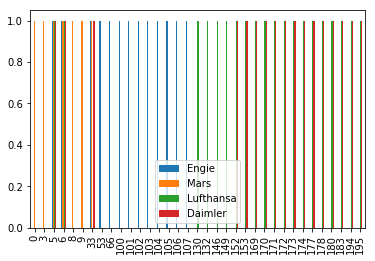

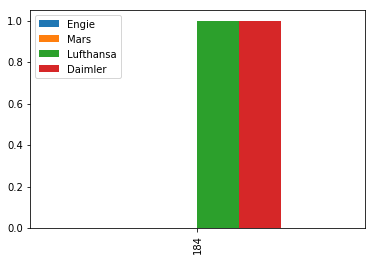

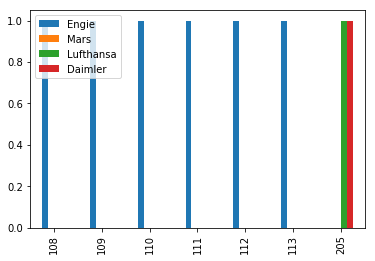

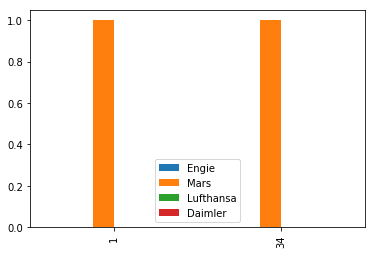

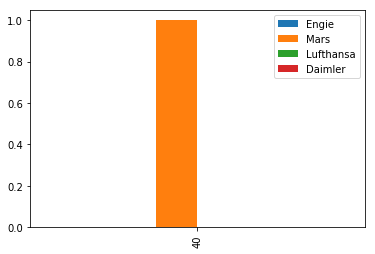

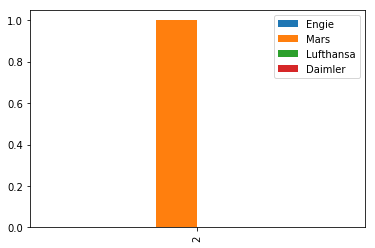

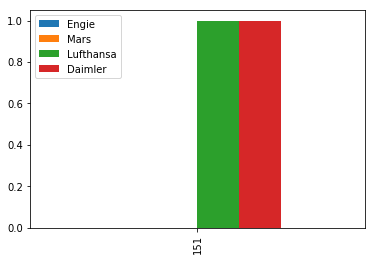

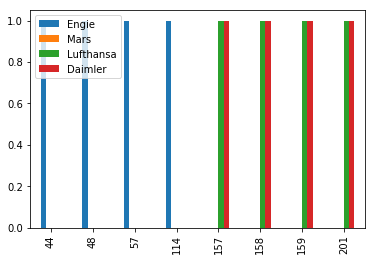

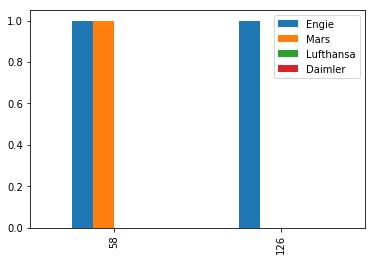

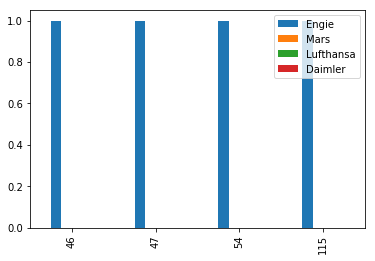

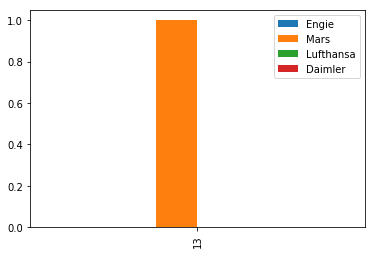

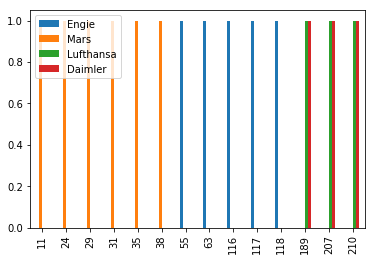

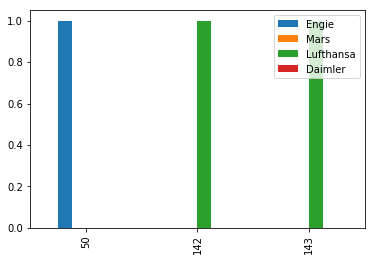

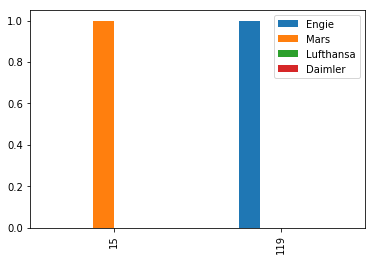

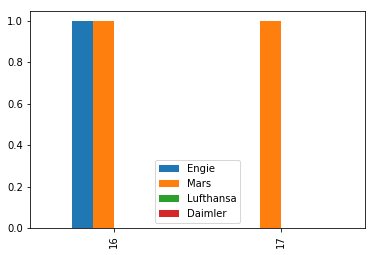

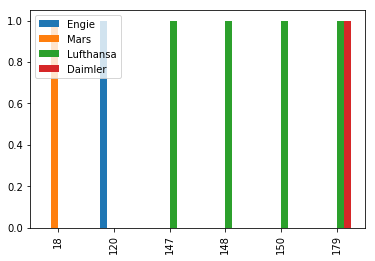

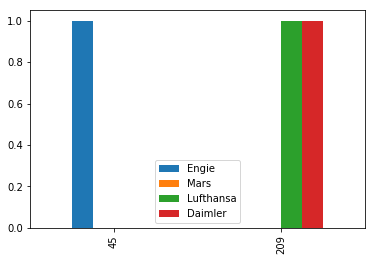

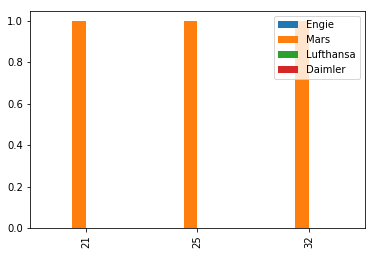

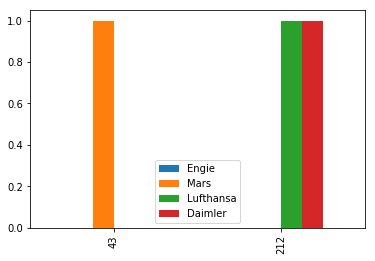

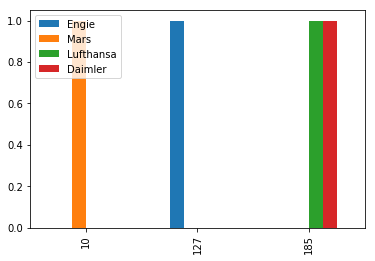

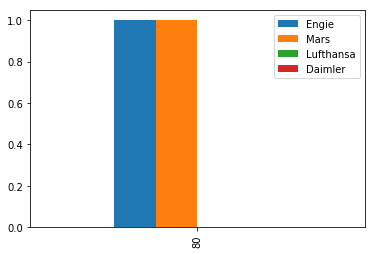

In [208]:
result.groupby('Message class')[['Engie','Mars','Lufthansa','Daimler']].plot(kind='bar')

In [220]:
import seaborn as sns


In [212]:
cls=result['Message class'].unique()

In [213]:
msgclass={}
num=1
for item in cls:
    msgclass[item]=num
    num+=1

In [216]:
result['MClassCode']=''

In [217]:
result.MClassCode=[msgclass[item] for item in result['Message class']]

In [219]:
result.head(20)

Message class  \
188          BF00   
81             BK   
75             BP   
52             BS   
121            CN   
82      DEFTAX_MX   
56             E!   
61             F2   
162            F2   
191            F2   
202            F4   
4              F5   
7              F5   
12             F5   
14             F5   
19             F5   
20             F5   
22             F5   
36             F5   
37             F5   

                                                                  Message text  \
188                                          Bank <bank number> does not exist   
81                            Assign a number range to business transaction &.   
75                                                       Bank Details missing    
52                                             System status ** is active (**)   
121                           WBS element &1 has different inventory valuation   
82   Deferred tax: Do not post invoice &1 with both acquisition and other taxe   
56                       Currency "**" is expiring; from **, use currency "**"   
61                                             Payment block ** is not defined   
162                     Payment block <payment block indicator> is not defined   
191                     Payment block <payment block indicator> is not defined   
202                                 Credit control area X has not been defined   
4                                       Debit/credit indicator is inconsistent   
7                                             Posting period ** ** is not open   
12                       G/L account ** is not defined in chart of accounts **   
14                                 Vendor ** is not defined in company code **   
19                                               Reason code ** is not defined   
20                           Special G/L indicator ** not defined or incorrect   
22                             Vendor ** has no bank details with indicator **   
36               Account ** in company code ** is not a reconciliation account   
37                                          No alternative payer/payee defined   

                                                                                                                                                                                                                                                                                                                                                              Resolution  \
188                                                                                                                                                                                                                                                              Make sure Bank information (BSEC-BANKN, BANKL, BANKS, IBAN) is cleared in CPD vendor/customer position.   
81                                                                                                                                                                                                                                                                                                              need to assign number range of Co document in tcode KANK   
75   This error occurrs for STAR rollout , generally in STAR rollout we need to create a ONE TIME Vendor/Customer, which not gets created by BP automation tool. As it requires external number range. We need to create it manually , its hardly one or two the number range we provide as TAXXXXXXXX and validated in LFA1 or KNA1 table there is one time vendor tick   
52                                                                                                                                                                                                                                                                     This error results due to closed status of target IO. Target IO need to be set in Released State.   
121                

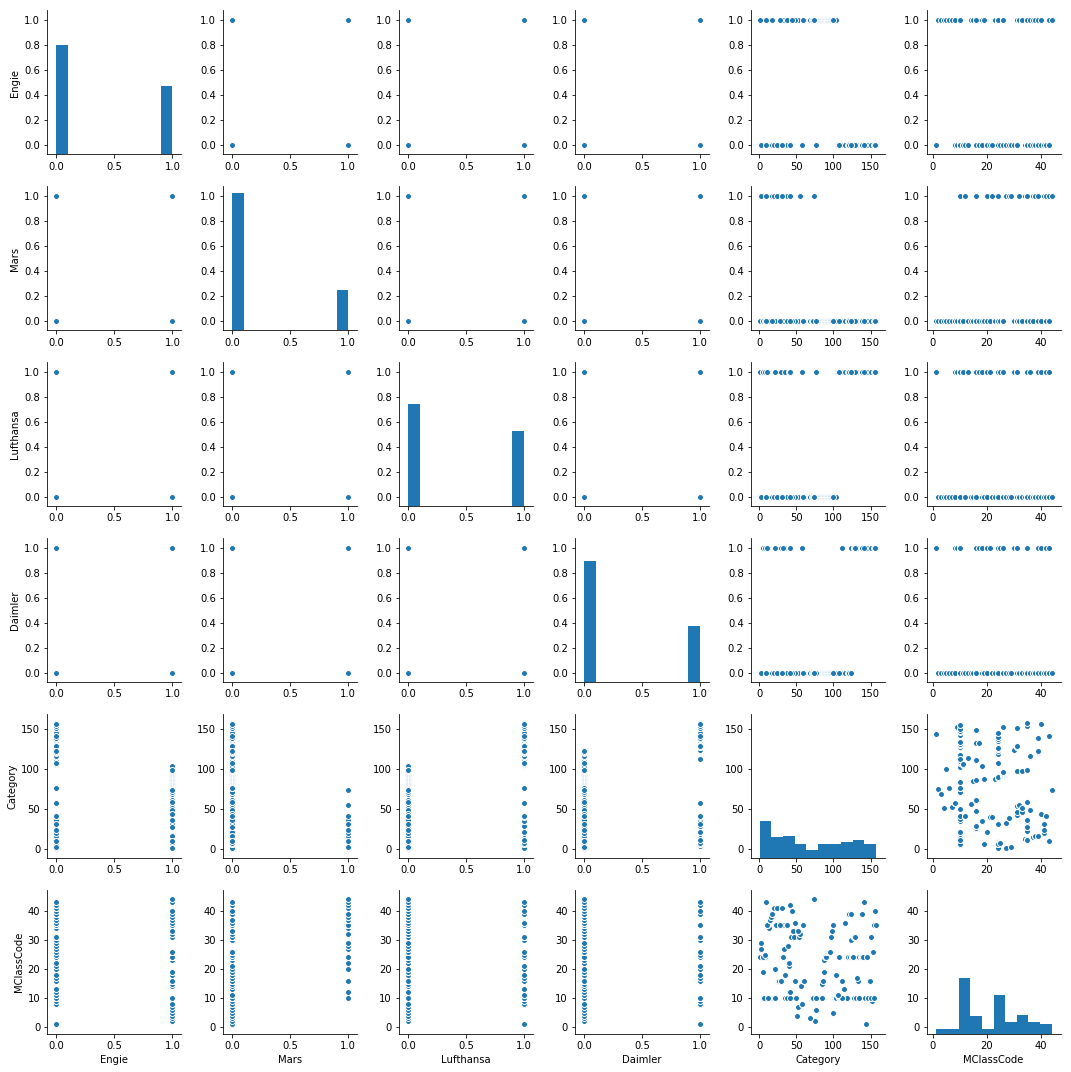

In [221]:
sns.pairplot(result)


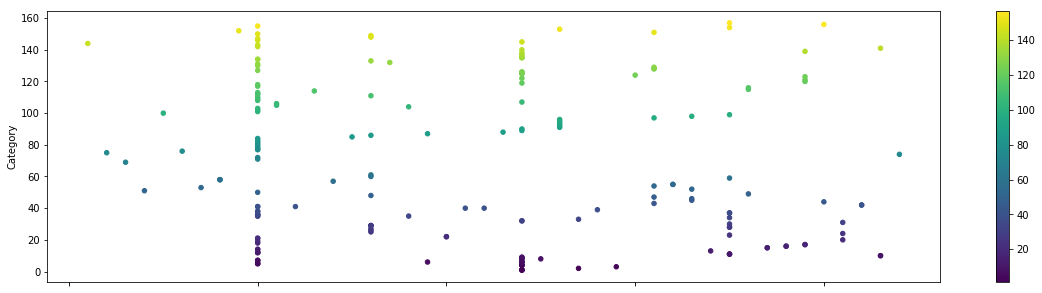

In [238]:
result[['MClassCode','Category']].plot(kind='scatter',x='MClassCode',y='Category',c=result['Category'],colormap='viridis',figsize=(20,5))

In [ ]:
result.to_csv("FIErrorsH.csv",sep=',',encoding='utf-8',index=False)

# Day 2

In [25]:
result=pd.read_csv("FIErrorsH.csv")

In [33]:
result["Message class"]=result["Message class"].apply(lambda x:preprocess_string(x[0],CUSTOM_FILTERS2)[0])

In [34]:
result.head()

Message class                                      Message text  \
0          BF00                 Bank <bank number> does not exist   
1            BK  Assign a number range to business transaction &.   
2            BP                             Bank Details missing    
3            BS                   System status ** is active (**)   
4            CN  WBS element &1 has different inventory valuation   

                                                                                                                                                                                                                                                                                                                                                            Resolution  \
0                                                                                                                                                                                                                                                              Make sure Bank information (BSEC-BANKN, BANKL, BANKS, IBAN) is cleared in CPD vendor/customer position.   
1                                                                                                                                                                                                                                                                                                             need to assign number range of Co document in tcode KANK   
2  This error occurrs for STAR rollout , generally in STAR rollout we need to create a ONE TIME Vendor/Customer, which not gets created by BP automation tool. As it requires external number range. We need to create it manually , its hardly one or two the number range we provide as TAXXXXXXXX and validated in LFA1 or KNA1 table there is one time vendor tick   
3                                                                                                                                                                                                                                                                    This error results due to closed status of target IO. Target IO need to be set in Released State.   
4                                                                                                                                                                                                                                                                                                   not came into active sprint, AIF related master replication issue    

   Engie  Mars  Lufthansa  Daimler  Category  MClassCode  
0      0     0          1        1       144           1  
1      1     0          0        0        75           2  
2      1     0          0        0        69           3  
3      1     0          0        0        51           4  
4      1     0          0        0       100           5

In [35]:
cls=result['Message class'].unique()

In [36]:
msgclass={}
num=1
for item in cls:
    msgclass[item]=num
    num+=1

In [37]:
result['MClassCode']=''

In [38]:
result.MClassCode=[msgclass[item] for item in result['Message class']]

In [39]:
max(result['MClassCode'])

40

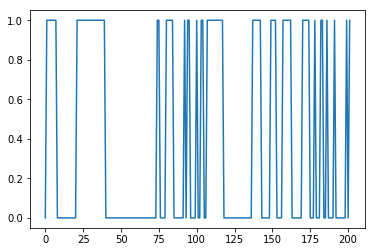

In [6]:
result['Engie'].plot()

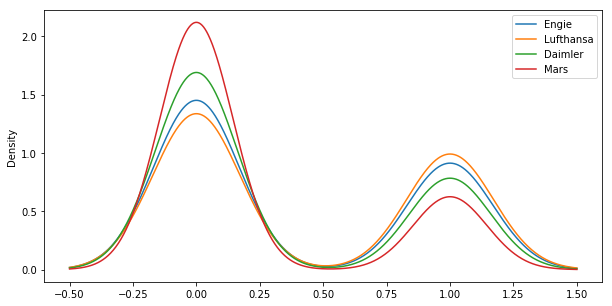

In [48]:
result[['MClassCode','Engie','Lufthansa','Daimler','Mars']].plot(kind='kde',x='MClassCode',y=['Engie','Lufthansa','Daimler','Mars'],figsize=(10,5))

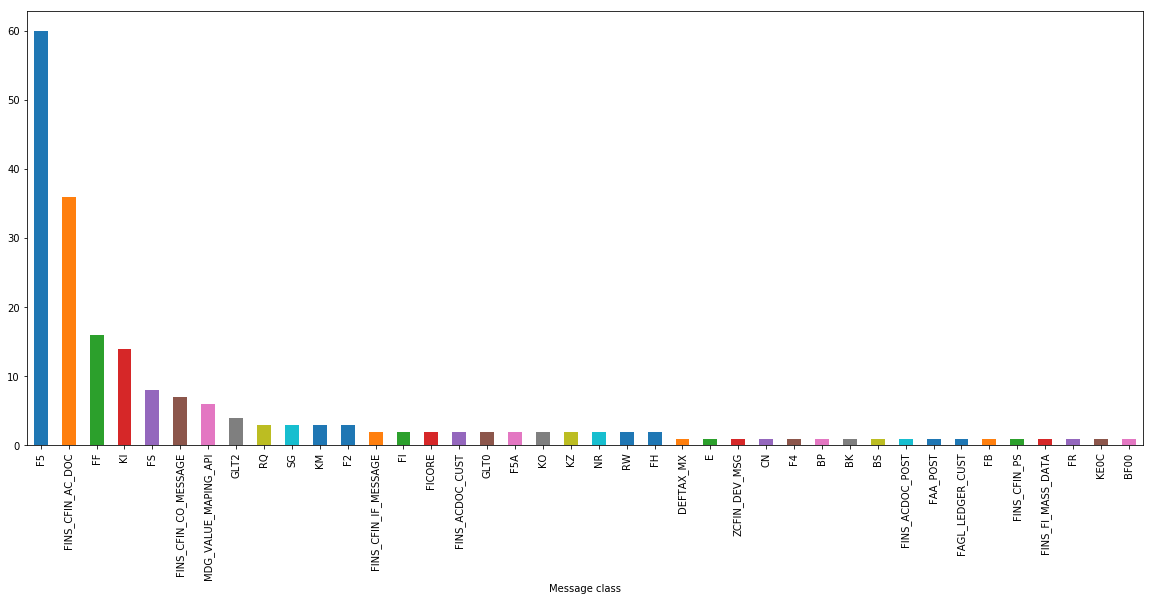

In [43]:
result.groupby(['Message class'])['Message text'].count().sort_values(ascending=False).plot(kind='bar',figsize=(20,8))

In [91]:
len(result.groupby(['Message class']).groups)

40

In [92]:
max(result["MClassCode"])

40

In [58]:
result=result.sort_values(by=['MClassCode','Category']).reset_index(drop=True)

In [98]:
result[result['Message class']=='F5'][['Message class','Message text']]

Message class  \
11            F5   
12            F5   
13            F5   
14            F5   
15            F5   
16            F5   
17            F5   
18            F5   
19            F5   
20            F5   
21            F5   
22            F5   
23            F5   
24            F5   
25            F5   
26            F5   
27            F5   
28            F5   
29            F5   
30            F5   
31            F5   
32            F5   
33            F5   
34            F5   
35            F5   
36            F5   
37            F5   
38            F5   
39            F5   
40            F5   
41            F5   
42            F5   
43            F5   
44            F5   
45            F5   
46            F5   
47            F5   
48            F5   
49            F5   
50            F5   
51            F5   
52            F5   
53            F5   
54            F5   
55            F5   
56            F5   
57            F5   
58            F5   
59            F5   
60            F5   
61            F5   
62            F5   
63            F5   
64            F5   
65            F5   
66            F5   
67            F5   
68            F5   
69            F5   
70            F5   

                                                                                Message text  
11                                                    Debit/credit indicator is inconsistent  
12                                                    Debit/credit indicator is inconsistent  
13                                                    Debit/credit indicator is inconsistent  
14                                                          Posting period ** ** is not open  
15                                                          Posting period &1 &2 is not open  
16                                     Posting period <posting period ID> <year> is not open  
17                                     G/L account ** is not defined in chart of accounts **  
18                                     G/L account &1 is not defined in chart of accounts &2  
19     G/L account  <account number> is not defined in chart of accounts <chart of accounts>  
20     G/L account  <account number> is not defined in chart of accounts <chart of accounts>  
21                                               Vendor ** is not defined in company code **  
22                      Vendor <vendor number> is not defined in company code <company code>  
23                                                             Reason code ** is not defined  
24                                         Special G/L indicator ** not defined or incorrect  
25                                           Vendor ** has no bank details with indicator **  
26                       Vendor <vendor number> has no bank details with indicator <bank ID>  
27                             Account ** in company code ** is not a reconciliation account  
28  Account  <account number> in company code <company code> is not a reconciliation account  
29                                                        No alternative payer/payee defined  
30                                                        No alternative payer/payee defined  
31                                                        No alternative payer/payee defined  
32                                Reconciliation account ** or short key ** is not permitted  
33         Reconciliation account <account number> or short key <short key> is not permitted  
34                                          G/L account &1 is not defined in company code &2  
35                                            G/L account x is not defined in company code y  
36                 G/L account ** is not defined in company code **                           
37                                     Tax does not equal 0 when tax percentage rate is zero  
38                                                     Customer not extended to company code  
39                         

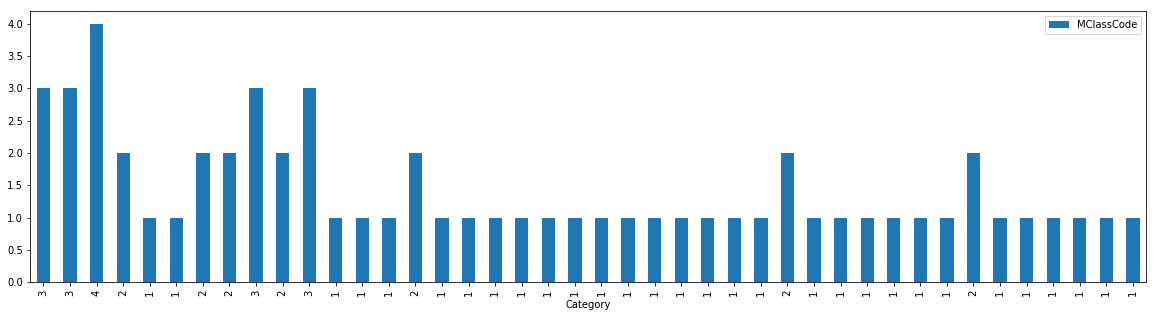

In [89]:
result[result['MClassCode']==10].groupby('Category')[['MClassCode','Category']].count().plot(kind='bar',figsize=(20,5),x='Category')

In [80]:
a=list(result[result['MClassCode']==10]['Category'])

In [81]:
type(a)

list

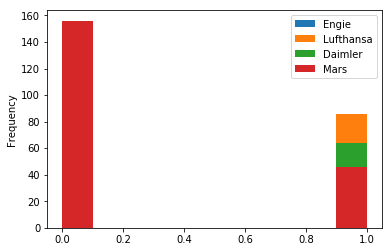

In [108]:
result[['Engie','Lufthansa','Daimler','Mars']].plot(kind='hist')

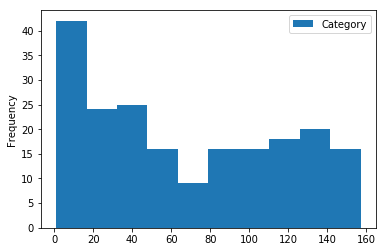

In [172]:
result[['Category']].plot(kind='hist')

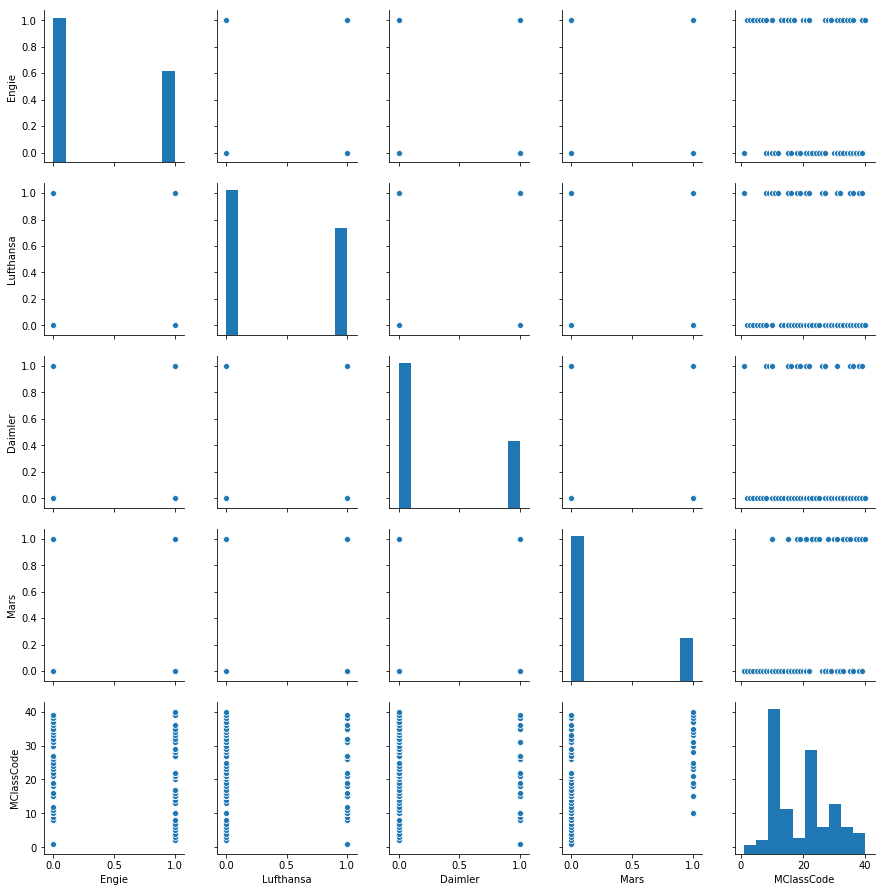

In [120]:
sns.pairplot(result[['Engie','Lufthansa','Daimler','Mars','MClassCode']])

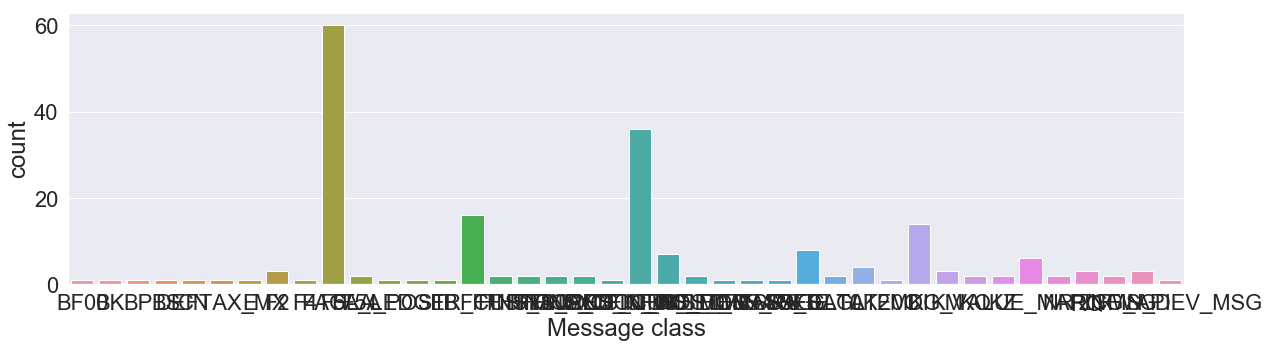

In [246]:
plt.subplots(figsize=(20,5))
sns.countplot(x='Message class',data=result[['Category','Message class']])

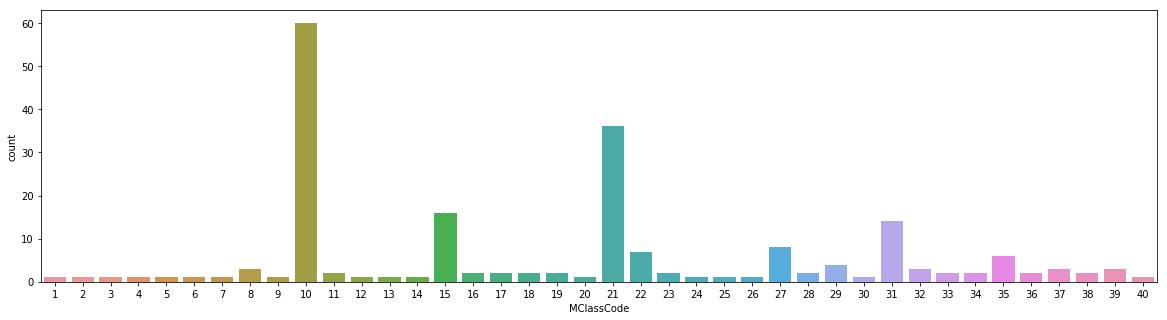

In [163]:
plt.subplots(figsize=(20,5))
sns.countplot(x='MClassCode',data=result[['Engie','Lufthansa','Daimler','Mars','MClassCode']])

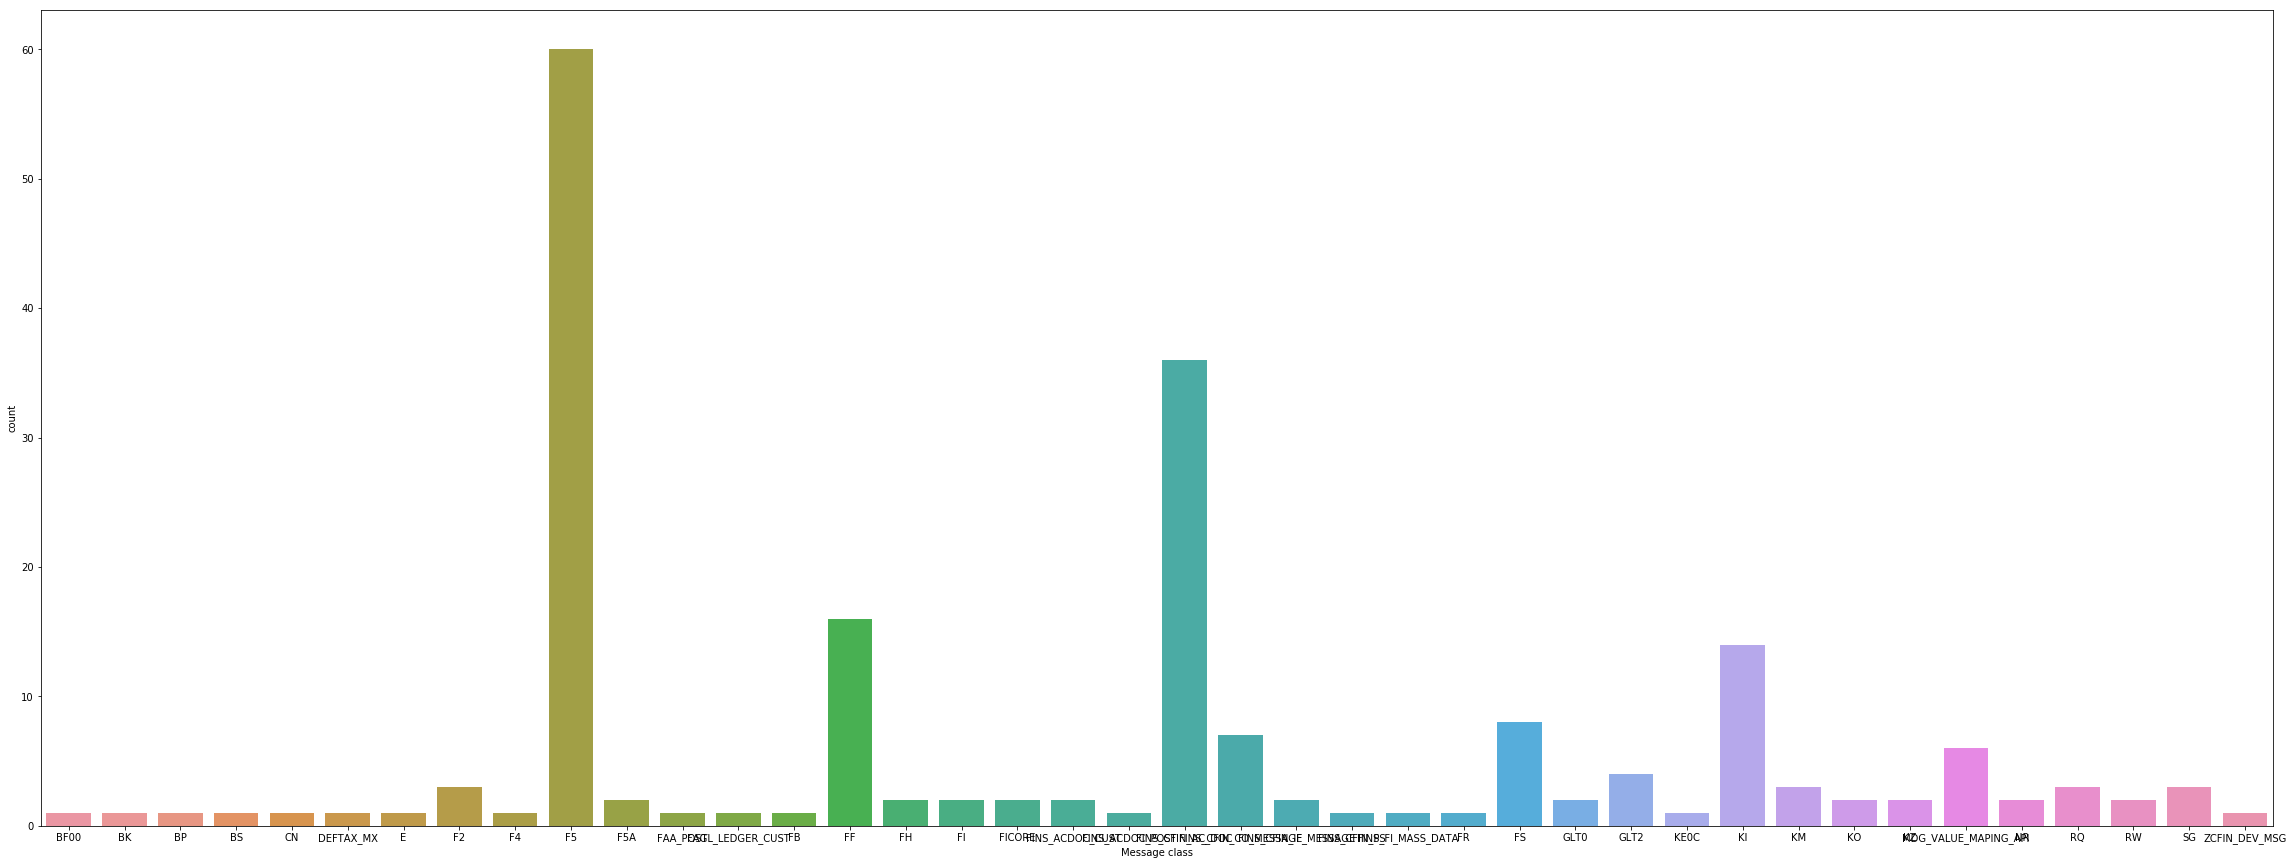

In [158]:
plt.subplots(figsize=(40,15))
sns.countplot(x='Message class',data=result[['Message class']])

In [134]:
result[result["Engie"]==1][['Message text','MClassCode']]

Message text  \
1                             Assign a number range to business transaction &.   
2                                                        Bank Details missing    
3                                              System status ** is active (**)   
4                             WBS element &1 has different inventory valuation   
5    Deferred tax: Do not post invoice &1 with both acquisition and other taxe   
6                        Currency "**" is expiring; from **, use currency "**"   
7                                              Payment block ** is not defined   
12                                      Debit/credit indicator is inconsistent   
15                                            Posting period &1 &2 is not open   
18                       G/L account &1 is not defined in chart of accounts &2   
30                                          No alternative payer/payee defined   
34                            G/L account &1 is not defined in company code &2   
37                       Tax does not equal 0 when tax percentage rate is zero   
38                                       Customer not extended to company code   
39                                         Vendor Not extended to Company Code   
40   No special G/L acct defined for acct type &1 sp.G/L ind. &2 recon.acct &3   
42                                   The entry &2 &3 &4 is missing in table &1   
43                                     Complete withholding tax amount details   
44                           Account type & is not defined for document type &   
45                                       Maximum number of items in FI reached   
46     No accts maintained for company code clearing between comp.cds & and &.   
47                                            Text for posting key & not found   
48                                             Dunning block &1 is not defined   
49           Exchange rate diff.accts are not defined for account & currency &   
50                      Special G/L posting to one-time account is not defined   
51      Postings to account & (company code &) are only possible in currency &   
74                                                   Ledger group &1 not found   
75                                                   Company &1 is not defined   
80                       Error in account determination: table &1 key &2 &3 &4   
83                    Cannot post document: tax base in local currency is zero   
84        G/L account item without tax code in document ** with deferred taxes   
85                            ** ** ** **  ( KSHCL is not equal to MWAS/MWVS )   
86                        The tax amount must not be greater than the tax base   
93                                Account &1 does not exist in company code &2   
94    No code list configured for Type **, GDT **, List-ID ** and Bus. Sys. **   
95                     No controlling area has been assigned to company code &   
100      Document cannot be posted, create an incident with ref. "&1 &2 &3 &4"   
102  Config. of substitution account for account ** in company code ** missing   
103  Config. of substitution account for account &1 in company code &2 missing   
106        Value ** of type ** in field '**' could not be mapped; see error **   
107        Value &2 of type &1 in field '&3' could not be mapped; see error &4   
108                      Value &2 of type &1 in field '&3' could not be mapped   
109   No code list configured for Type **, GDT **, List-ID ** and Bus. Sys. **   
110   No code list configured for Type &1, GDT &2, List-ID &3 and Bus. Sys. &4   
114  Referenced document not yet posted (Comp.Code &1, F.Year &2, Document &3)   
117         Referenced invoice not yet posted (CC &1, FY &2, Doc. &3, Item &4)   
118              Internal representation for unit of measure ** does not exist   
119              Internal representation for unit of measure ** does not exist   
120              Business system for logical sys

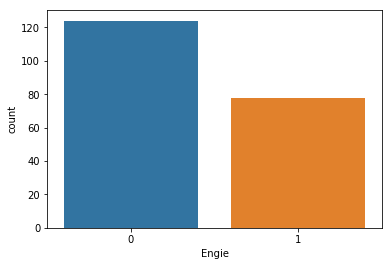

In [137]:
sns.countplot(x='Engie',data=result[['Engie','MClassCode']])

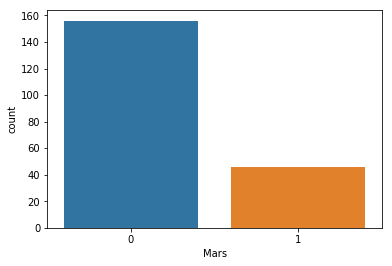

In [139]:
sns.countplot(x='Mars',data=result[['Mars','MClassCode']])

In [143]:
result[(result['Mars']==1) & (result['Engie']==1)& (result['Daimler']==1)& (result['Lufthansa']==1)]

Message class  \
106  FINS_CFIN_AC_DOC   
109  FINS_CFIN_AC_DOC   

                                                                 Message text  \
106       Value ** of type ** in field '**' could not be mapped; see error **   
109  No code list configured for Type **, GDT **, List-ID ** and Bus. Sys. **   

                                                                                                                                                                    Resolution  \
106  Check & Complete the missing MDG Mapping for the oject which you face the error\r\r\nFor Exapmple: Company Code Mapping, Tax Code Mapping, GL Mapping & other all Mapping   
109                                                                                  Check & Complete the missing mapping for code list fr othe object which we face the error   

     Engie  Mars  Lufthansa  Daimler  Category  MClassCode  
106      1     1          1        1         4          21  
109      1     1          1        1         6          21

In [145]:
result[(result['Message class']=='FINS_CFIN_AC_DOC')]

Message class  \
101  FINS_CFIN_AC_DOC   
102  FINS_CFIN_AC_DOC   
103  FINS_CFIN_AC_DOC   
104  FINS_CFIN_AC_DOC   
105  FINS_CFIN_AC_DOC   
106  FINS_CFIN_AC_DOC   
107  FINS_CFIN_AC_DOC   
108  FINS_CFIN_AC_DOC   
109  FINS_CFIN_AC_DOC   
110  FINS_CFIN_AC_DOC   
111  FINS_CFIN_AC_DOC   
112  FINS_CFIN_AC_DOC   
113  FINS_CFIN_AC_DOC   
114  FINS_CFIN_AC_DOC   
115  FINS_CFIN_AC_DOC   
116  FINS_CFIN_AC_DOC   
117  FINS_CFIN_AC_DOC   
118  FINS_CFIN_AC_DOC   
119  FINS_CFIN_AC_DOC   
120  FINS_CFIN_AC_DOC   
121  FINS_CFIN_AC_DOC   
122  FINS_CFIN_AC_DOC   
123  FINS_CFIN_AC_DOC   
124  FINS_CFIN_AC_DOC   
125  FINS_CFIN_AC_DOC   
126  FINS_CFIN_AC_DOC   
127  FINS_CFIN_AC_DOC   
128  FINS_CFIN_AC_DOC   
129  FINS_CFIN_AC_DOC   
130  FINS_CFIN_AC_DOC   
131  FINS_CFIN_AC_DOC   
132  FINS_CFIN_AC_DOC   
133  FINS_CFIN_AC_DOC   
134  FINS_CFIN_AC_DOC   
135  FINS_CFIN_AC_DOC   
136  FINS_CFIN_AC_DOC   

                                                                                                                              Message text  \
101                                                              Config. of substitution account for account ** in company code ** missing   
102                                                              Config. of substitution account for account ** in company code ** missing   
103                                                              Config. of substitution account for account &1 in company code &2 missing   
104                                                                Config. of substitution account for account x in <company code> missing   
105                                                                                  Value ** of type ** in field '**' could not be mapped   
106                                                                    Value ** of type ** in field '**' could not be mapped; see error **   
107                                                                    Value &2 of type &1 in field '&3' could not be mapped; see error &4   
108                                                                                  Value &2 of type &1 in field '&3' could not be mapped   
109                                                               No code list configured for Type **, GDT **, List-ID ** and Bus. Sys. **   
110                                                               No code list configured for Type &1, GDT &2, List-ID &3 and Bus. Sys. &4   
111                                                 No code list configured for Type DTEL, GDT WT_WITHCD, List-ID    FE and Bus. Sys. XXXX   
112                                                 No code list configured for Type DTEL, GDT WT_WITHCD, List-ID    FE and Bus. Sys. XXXX   
113                                                              Referenced document not yet posted (Comp.Code **, F.Year **, Document **)   
114                                                              Referenced document not yet posted (Comp.Code &1, F.Year &2, Document &3)   
115                                                     Referenced document not yet posted (Comp.Code xxxx, F.Year xxxx,<Document Number>)   
116                                                                     Referenced invoice not yet posted (CC **, FY **, Doc. **, Item **)   
117                                                                     Referenced invoice not yet posted (CC &1, FY &2, Doc. &3, Item &4)   
118                                                                          Internal representation for unit of measure ** does not exist   
119                                                                          Internal representation for unit of measure ** does not exist   
120                                                                          Business system for logical system &1 could not be determined   
121                                                                                         Unexpect

In [146]:
result[(result['Mars']==0) & (result['Engie']==0)& (result['Daimler']==0)& (result['Lufthansa']==0)]

Empty DataFrame
Columns: [Message class, Message text, Resolution, Engie, Mars, Lufthansa, Daimler, Category, MClassCode]
Index: []

In [148]:
result[(result['Mars']==1)][['Message class','Message text','Category']]

Message class  \
11                     F5   
14                     F5   
17                     F5   
21                     F5   
23                     F5   
24                     F5   
25                     F5   
27                     F5   
29                     F5   
32                     F5   
36                     F5   
76                     FF   
77                     FF   
78                     FF   
79                     FF   
96                 FICORE   
99        FINS_ACDOC_CUST   
101      FINS_CFIN_AC_DOC   
105      FINS_CFIN_AC_DOC   
106      FINS_CFIN_AC_DOC   
109      FINS_CFIN_AC_DOC   
113      FINS_CFIN_AC_DOC   
116      FINS_CFIN_AC_DOC   
118      FINS_CFIN_AC_DOC   
144  FINS_CFIN_IF_MESSAGE   
145  FINS_CFIN_IF_MESSAGE   
146          FINS_CFIN_PS   
147     FINS_FI_MASS_DATA   
157                  GLT0   
163                  KE0C   
164                    KI   
167                    KI   
168                    KI   
170                    KI   
171                    KI   
172                    KI   
181                    KO   
183                    KZ   
184                    KZ   
185  MDG_VALUE_MAPING_API   
193                    RQ   
194                    RQ   
195                    RQ   
196                    RW   
198                    SG   
201         ZCFIN_DEV_MSG   

                                                                  Message text  \
11                                      Debit/credit indicator is inconsistent   
14                                            Posting period ** ** is not open   
17                       G/L account ** is not defined in chart of accounts **   
21                                 Vendor ** is not defined in company code **   
23                                               Reason code ** is not defined   
24                           Special G/L indicator ** not defined or incorrect   
25                             Vendor ** has no bank details with indicator **   
27               Account ** in company code ** is not a reconciliation account   
29                                          No alternative payer/payee defined   
32                  Reconciliation account ** or short key ** is not permitted   
36   G/L account ** is not defined in company code **                            
76            Jurisdiction code ** is not defined for calculation procedure **   
77                System error in routine ** error code ** function builder **   
78               Company code ** requires you to enter a tax jurisdiction code   
79                       Error in account determination: table ** key ** ** **   
96                                      Tax code ** in procedure ** is invalid   
99   Default values for postings in Controlling not defined for CoCode **        
101  Config. of substitution account for account ** in company code ** missing   
105                      Value ** of type ** in field '**' could not be mapped   
106        Value ** of type ** in field '**' could not be mapped; see error **   
109   No code list configured for Type **, GDT **, List-ID ** and Bus. Sys. **   
113  Referenced document not yet posted (Comp.Code **, F.Year **, Document **)   
116         Referenced invoice not yet posted (CC **, FY **, Doc. **, Item **)   
118              Internal representation for unit of measure ** does not exist   
144       Document ** Company Code ** Fiscal Year ** has the following errors:   
145                  Cross Company document with Cross-CC Number ** is missing   
146                                                   WBS element ** not found   
147                           ** step ** failed for work package **; try again   
157    Document splitting causes field overflow for currency type ** in row **   
163          Characteristic value ** does not exist for characteristic ** (**)   
164                           Account ** requires an assignment to a CO object   
167   Cost element ** in

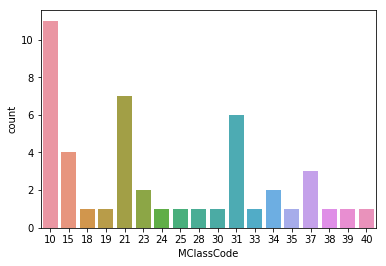

In [152]:
sns.countplot(data=result[(result['Mars']==1)],x='MClassCode')

In [250]:
result[result['Message class']=='F5']['Category']

11      5
12      5
13      5
14      7
15      7
16      7
17     12
18     12
19     12
20     12
21     14
22     14
23     18
24     19
25     21
26     21
27     35
28     35
29     36
30     36
31     36
32     38
33     38
34     41
35     41
36     41
37     50
38     71
39     72
40     77
41     77
42     78
43     79
44     80
45     81
46     82
47     83
48     84
49    101
50    102
51    103
52    108
53    109
54    110
55    112
56    112
57    113
58    117
59    118
60    127
61    130
62    131
63    134
64    134
65    142
66    143
67    146
68    147
69    150
70    155
Name: Category, dtype: int64

[Text(0, 0, 'Debit/credit indicator is inconsistent'),
 Text(0, 0, 'Posting period ** ** is not open'),
 Text(0, 0, 'Posting period &1 &2 is not open'),
 Text(0, 0, 'Posting period <posting period ID> <year> is not open'),
 Text(0, 0, 'G/L account ** is not defined in chart of accounts **'),
 Text(0, 0, 'G/L account &1 is not defined in chart of accounts &2'),
 Text(0, 0, 'G/L account  <account number> is not defined in chart of accounts <chart of accounts>'),
 Text(0, 0, 'Vendor ** is not defined in company code **'),
 Text(0, 0, 'Vendor <vendor number> is not defined in company code <company code>'),
 Text(0, 0, 'Reason code ** is not defined'),
 Text(0, 0, 'Special G/L indicator ** not defined or incorrect'),
 Text(0, 0, 'Vendor ** has no bank details with indicator **'),
 Text(0, 0, 'Vendor <vendor number> has no bank details with indicator <bank ID>'),
 Text(0, 0, 'Account ** in company code ** is not a reconciliation account'),
 Text(0, 0, 'Account  <account number> in company co

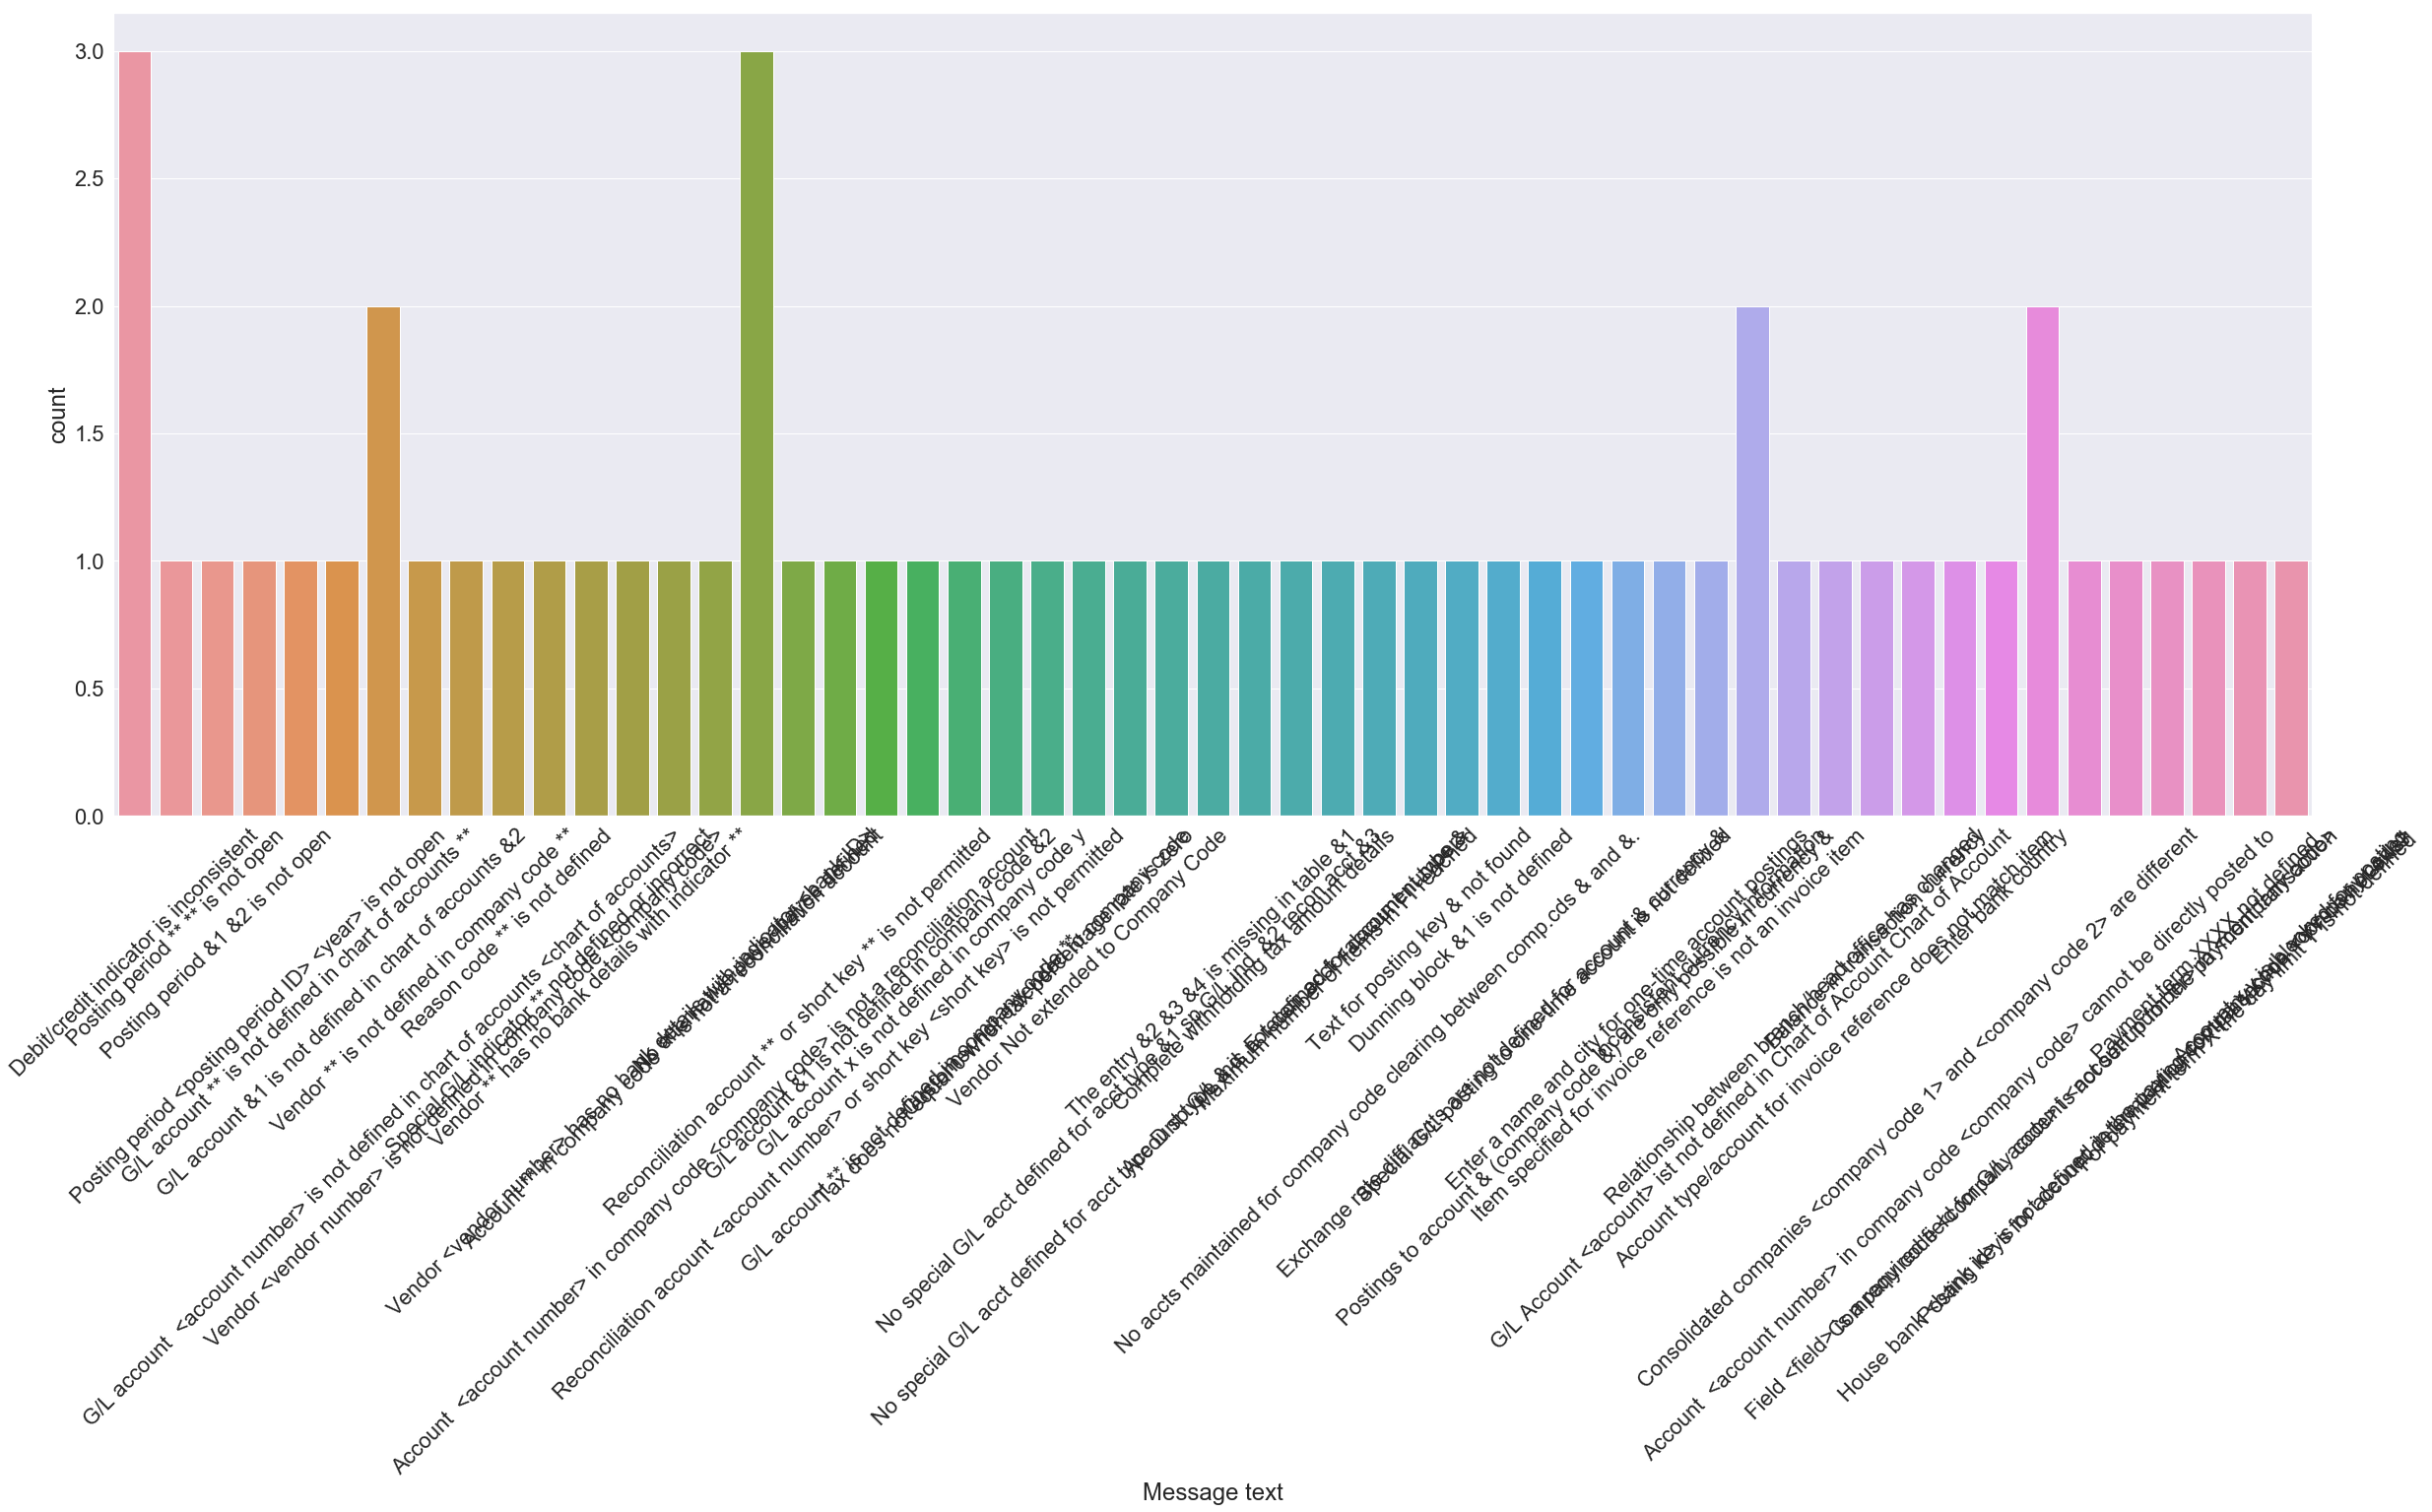

In [259]:
plt.subplots(figsize=(40,15))
sns.set(font_scale = 2)
g=sns.countplot(x='Message text',data=result[result['Message class']=='F5'])
g.set_xticklabels(g.get_xticklabels(), rotation=45)

[Text(0, 0, 'F5'),
 Text(0, 0, 'FF'),
 Text(0, 0, 'FICORE'),
 Text(0, 0, 'FINS_ACDOC_CUST'),
 Text(0, 0, 'FINS_CFIN_AC_DOC'),
 Text(0, 0, 'FINS_CFIN_IF_MESSAGE'),
 Text(0, 0, 'FINS_CFIN_PS'),
 Text(0, 0, 'FINS_FI_MASS_DATA'),
 Text(0, 0, 'GLT0'),
 Text(0, 0, 'KE0C'),
 Text(0, 0, 'KI'),
 Text(0, 0, 'KO'),
 Text(0, 0, 'KZ'),
 Text(0, 0, 'MDG_VALUE_MAPING_API'),
 Text(0, 0, 'RQ'),
 Text(0, 0, 'RW'),
 Text(0, 0, 'SG'),
 Text(0, 0, 'ZCFIN_DEV_MSG')]

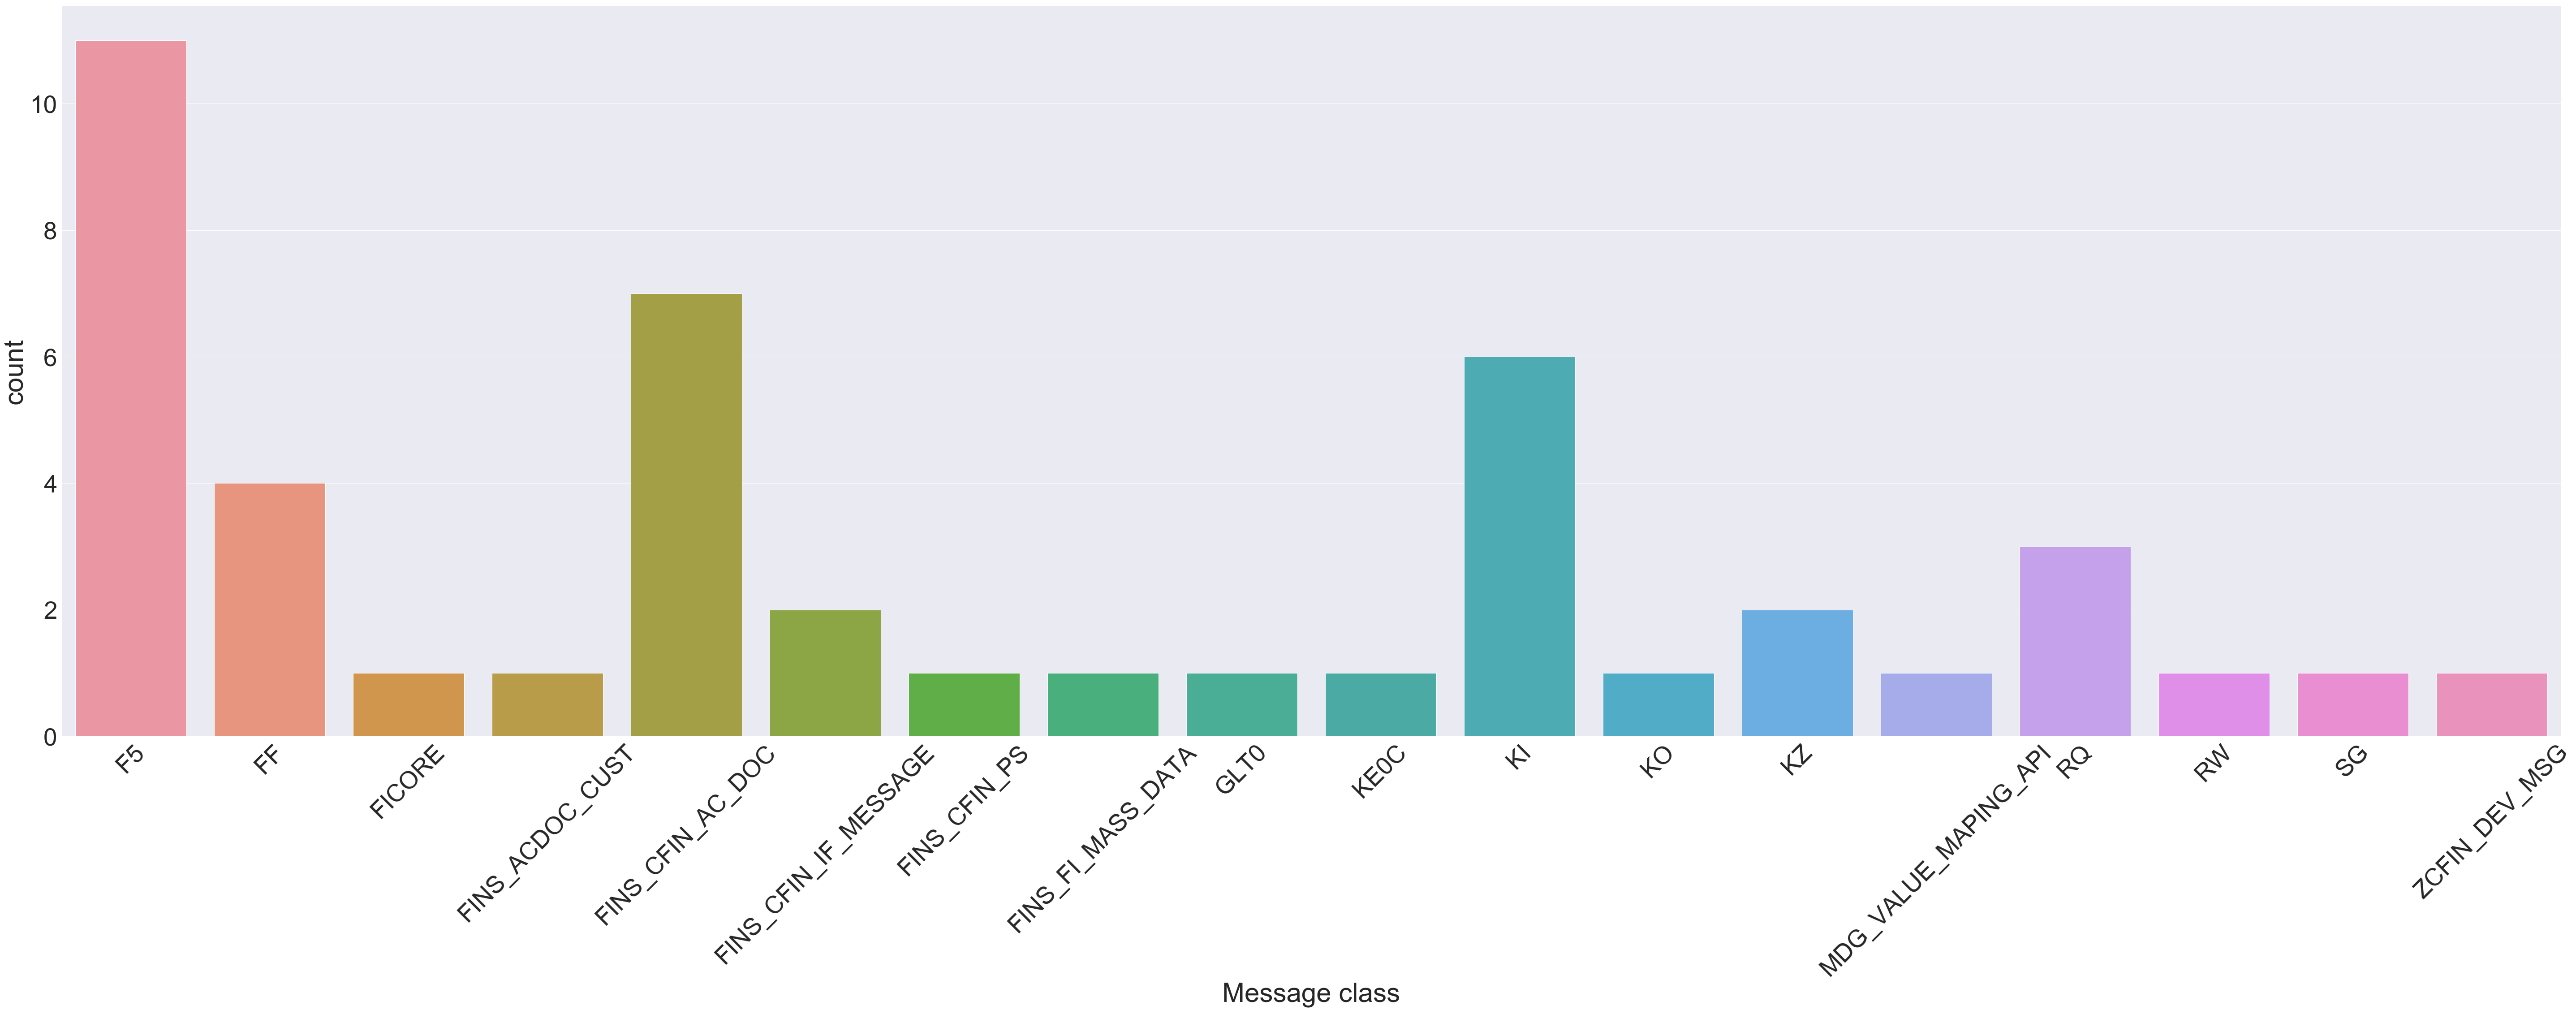

In [226]:
plt.subplots(figsize=(100,30))
sns.set(font_scale = 2)

d=sns.countplot(data=result[(result['Mars']==1)],x='Message class')
d.set_xticklabels(d.get_xticklabels(), rotation=45)

[Text(0, 0, 'BF00'),
 Text(0, 0, 'F2'),
 Text(0, 0, 'F4'),
 Text(0, 0, 'F5'),
 Text(0, 0, 'FF'),
 Text(0, 0, 'FH'),
 Text(0, 0, 'FICORE'),
 Text(0, 0, 'FINS_ACDOC_CUST'),
 Text(0, 0, 'FINS_CFIN_AC_DOC'),
 Text(0, 0, 'FINS_CFIN_CO_MESSAGE'),
 Text(0, 0, 'FR'),
 Text(0, 0, 'FS'),
 Text(0, 0, 'KI'),
 Text(0, 0, 'MDG_VALUE_MAPING_API'),
 Text(0, 0, 'NR'),
 Text(0, 0, 'RW'),
 Text(0, 0, 'SG')]

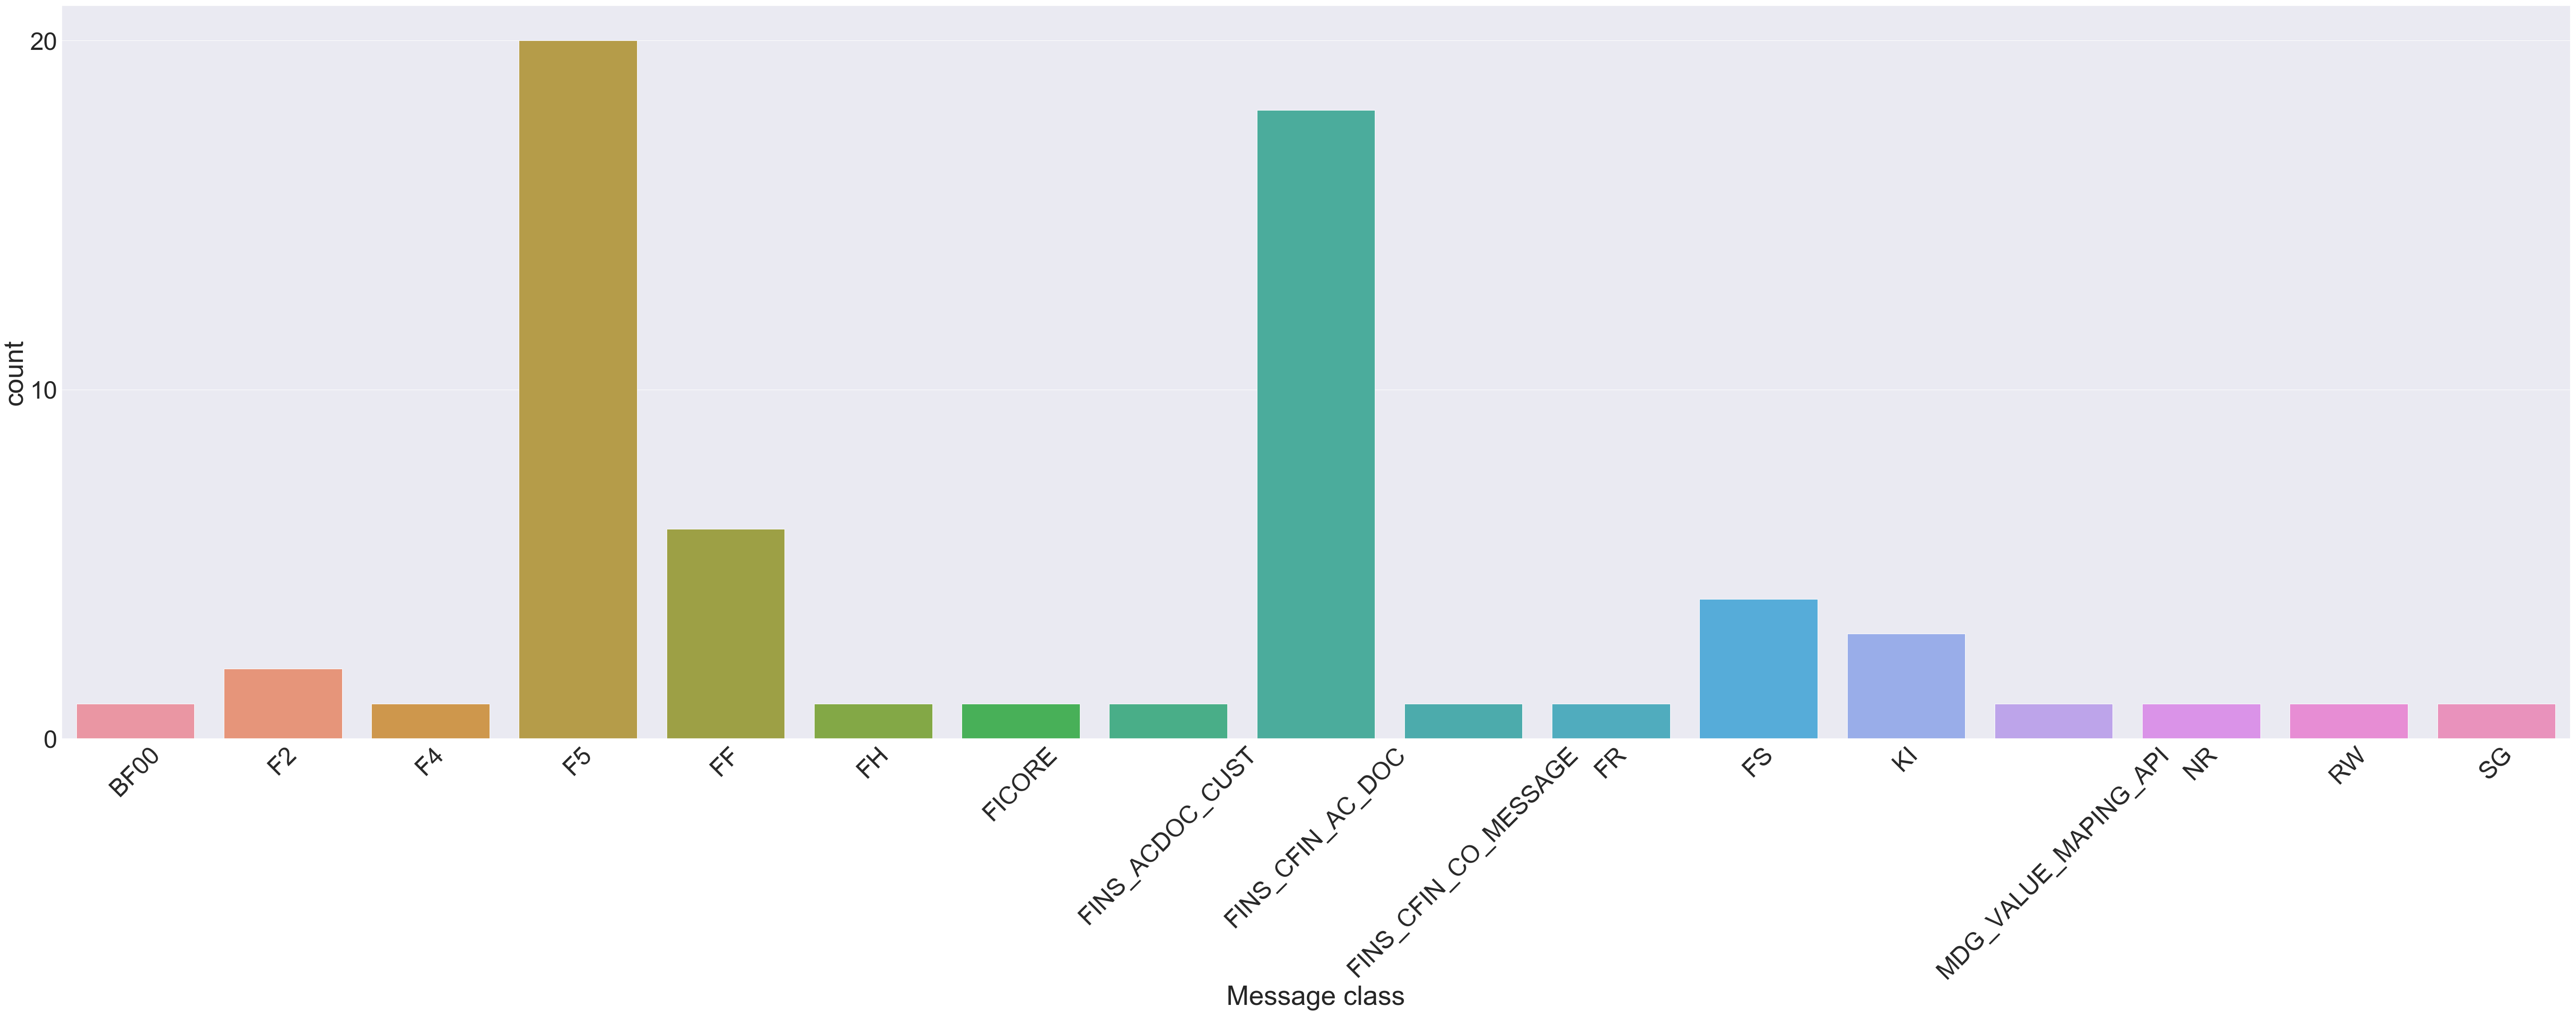

In [207]:
plt.subplots(figsize=(100,30))
sns.set(font_scale = 20)

d=sns.countplot(data=result[(result['Daimler']==1)],x='Message class')
d.set_xticklabels(d.get_xticklabels(), rotation=45)

[Text(0, 0, 'BF00'),
 Text(0, 0, 'F2'),
 Text(0, 0, 'F4'),
 Text(0, 0, 'F5'),
 Text(0, 0, 'F5A'),
 Text(0, 0, 'FAA_POST'),
 Text(0, 0, 'FF'),
 Text(0, 0, 'FH'),
 Text(0, 0, 'FICORE'),
 Text(0, 0, 'FINS_ACDOC_CUST'),
 Text(0, 0, 'FINS_CFIN_AC_DOC'),
 Text(0, 0, 'FINS_CFIN_CO_MESSAGE'),
 Text(0, 0, 'FR'),
 Text(0, 0, 'FS'),
 Text(0, 0, 'KI'),
 Text(0, 0, 'KM'),
 Text(0, 0, 'MDG_VALUE_MAPING_API'),
 Text(0, 0, 'NR'),
 Text(0, 0, 'RW'),
 Text(0, 0, 'SG')]

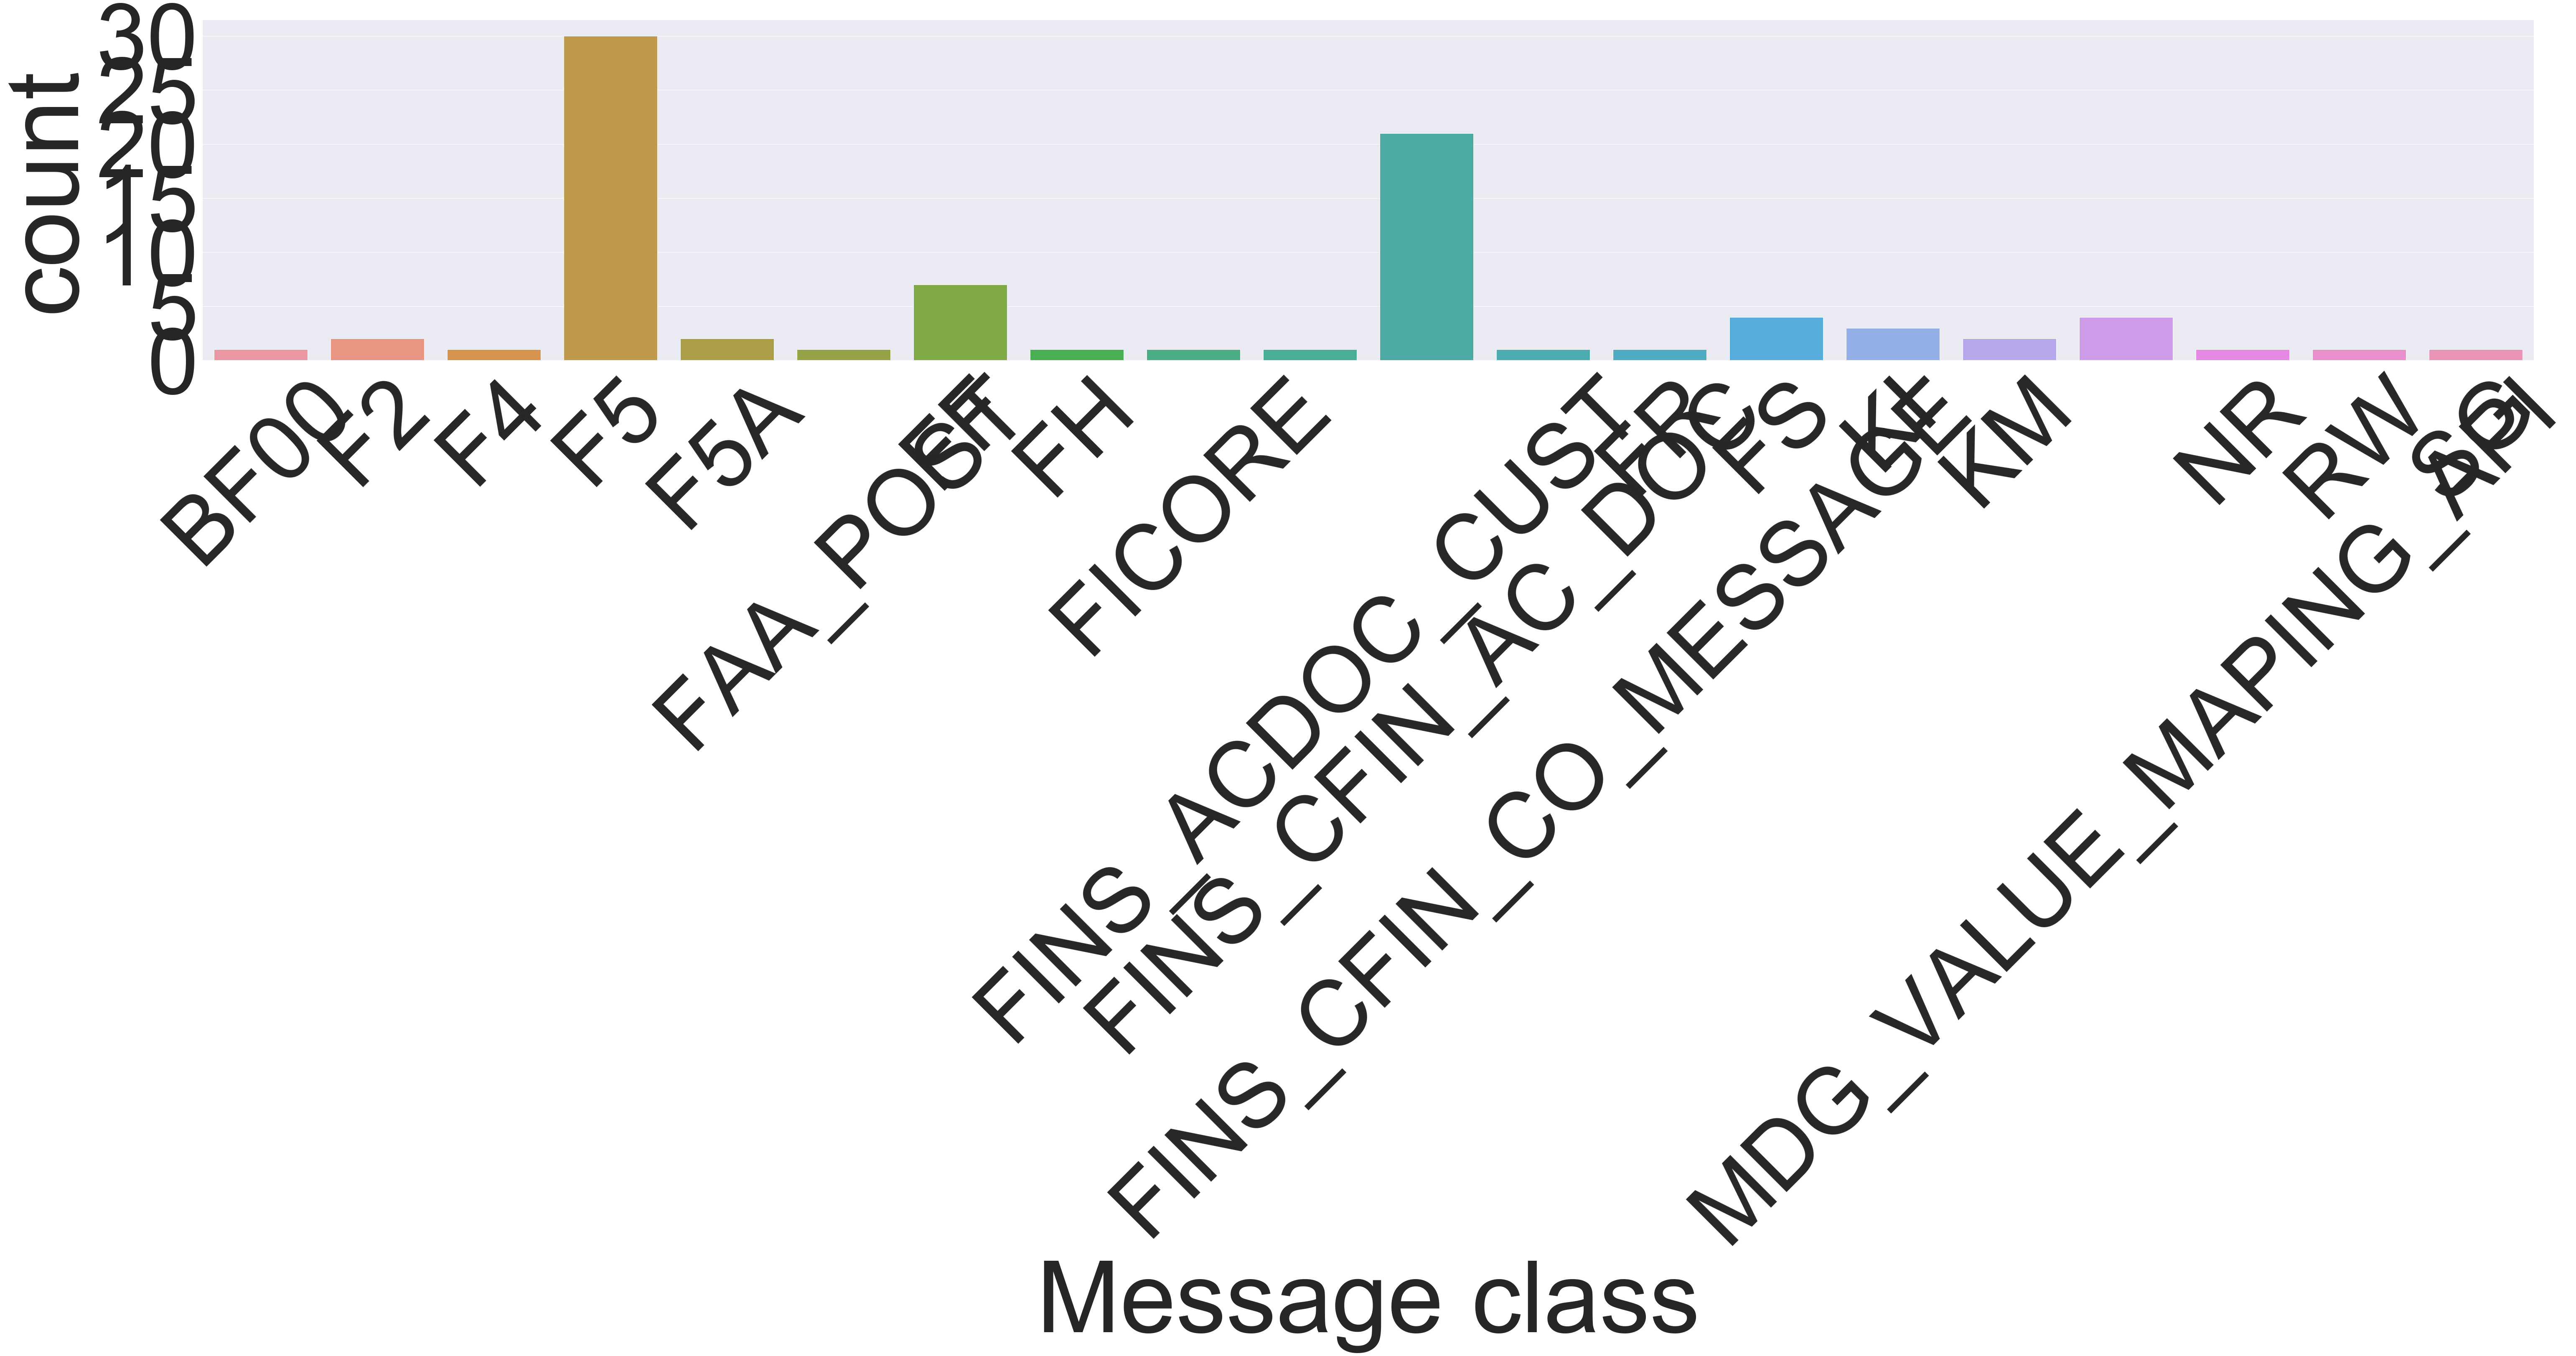

In [218]:
plt.subplots(figsize=(100,15))
sns.set(font_scale = 2)

d=sns.countplot(data=result[(result['Lufthansa']==1)],x='Message class')
d.set_xticklabels(d.get_xticklabels(), rotation=45)

[Text(0, 0, 'BK'),
 Text(0, 0, 'BP'),
 Text(0, 0, 'BS'),
 Text(0, 0, 'CN'),
 Text(0, 0, 'DEFTAX_MX'),
 Text(0, 0, 'E'),
 Text(0, 0, 'F2'),
 Text(0, 0, 'F5'),
 Text(0, 0, 'FAGL_LEDGER_CUST'),
 Text(0, 0, 'FB'),
 Text(0, 0, 'FF'),
 Text(0, 0, 'FH'),
 Text(0, 0, 'FI'),
 Text(0, 0, 'FINS_ACDOC_POST'),
 Text(0, 0, 'FINS_CFIN_AC_DOC'),
 Text(0, 0, 'FINS_CFIN_CO_MESSAGE'),
 Text(0, 0, 'FS'),
 Text(0, 0, 'GLT0'),
 Text(0, 0, 'GLT2'),
 Text(0, 0, 'KI'),
 Text(0, 0, 'KM'),
 Text(0, 0, 'KO'),
 Text(0, 0, 'KZ'),
 Text(0, 0, 'MDG_VALUE_MAPING_API'),
 Text(0, 0, 'NR'),
 Text(0, 0, 'SG'),
 Text(0, 0, 'ZCFIN_DEV_MSG')]

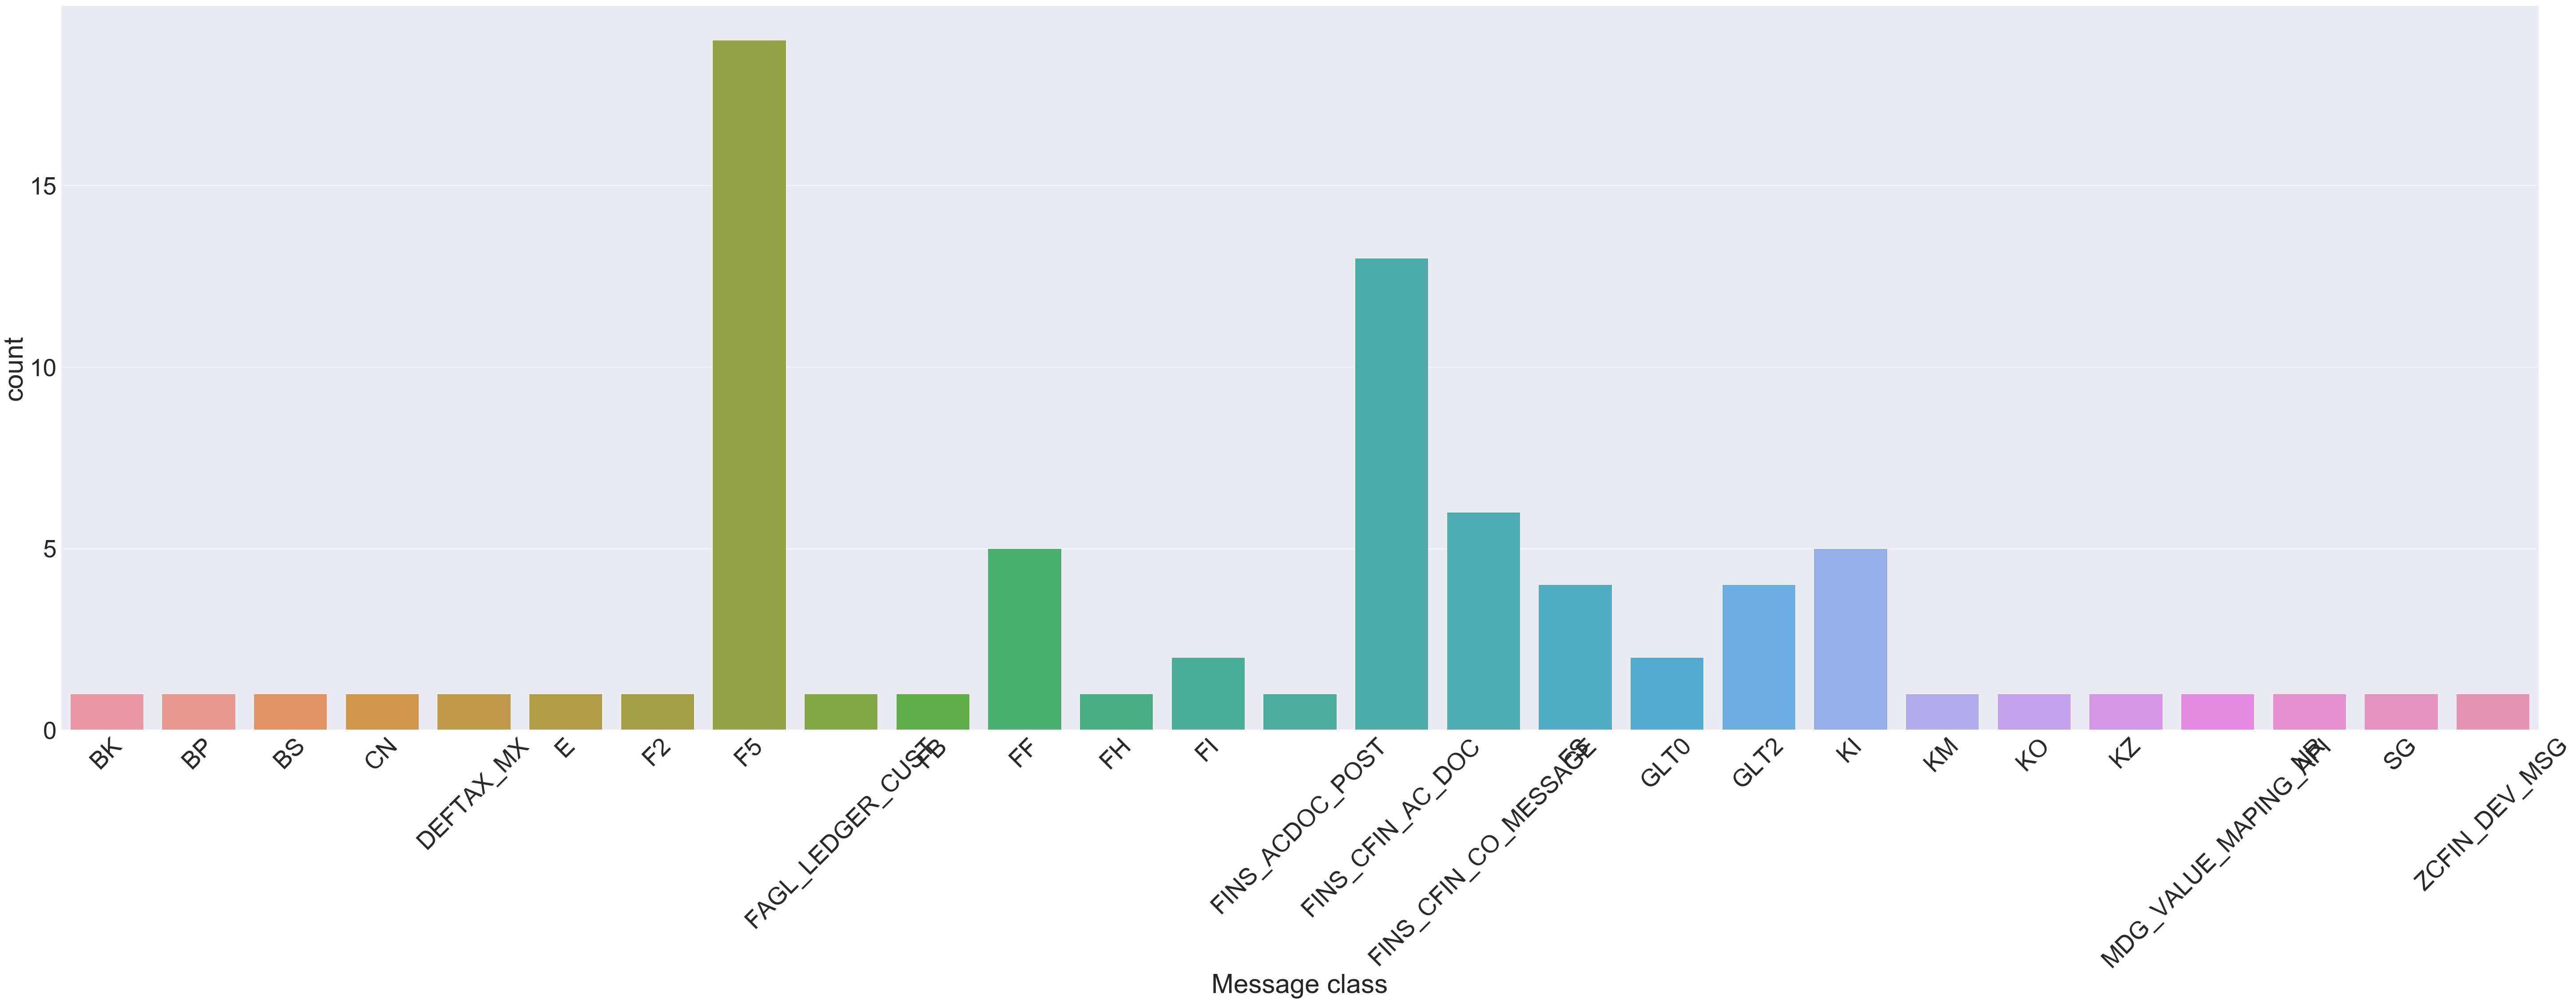

In [220]:
plt.subplots(figsize=(100,30))
sns.set(font_scale = 15)

d=sns.countplot(data=result[(result['Engie']==1)],x='Message class')
d.set_xticklabels(d.get_xticklabels(), rotation=45)

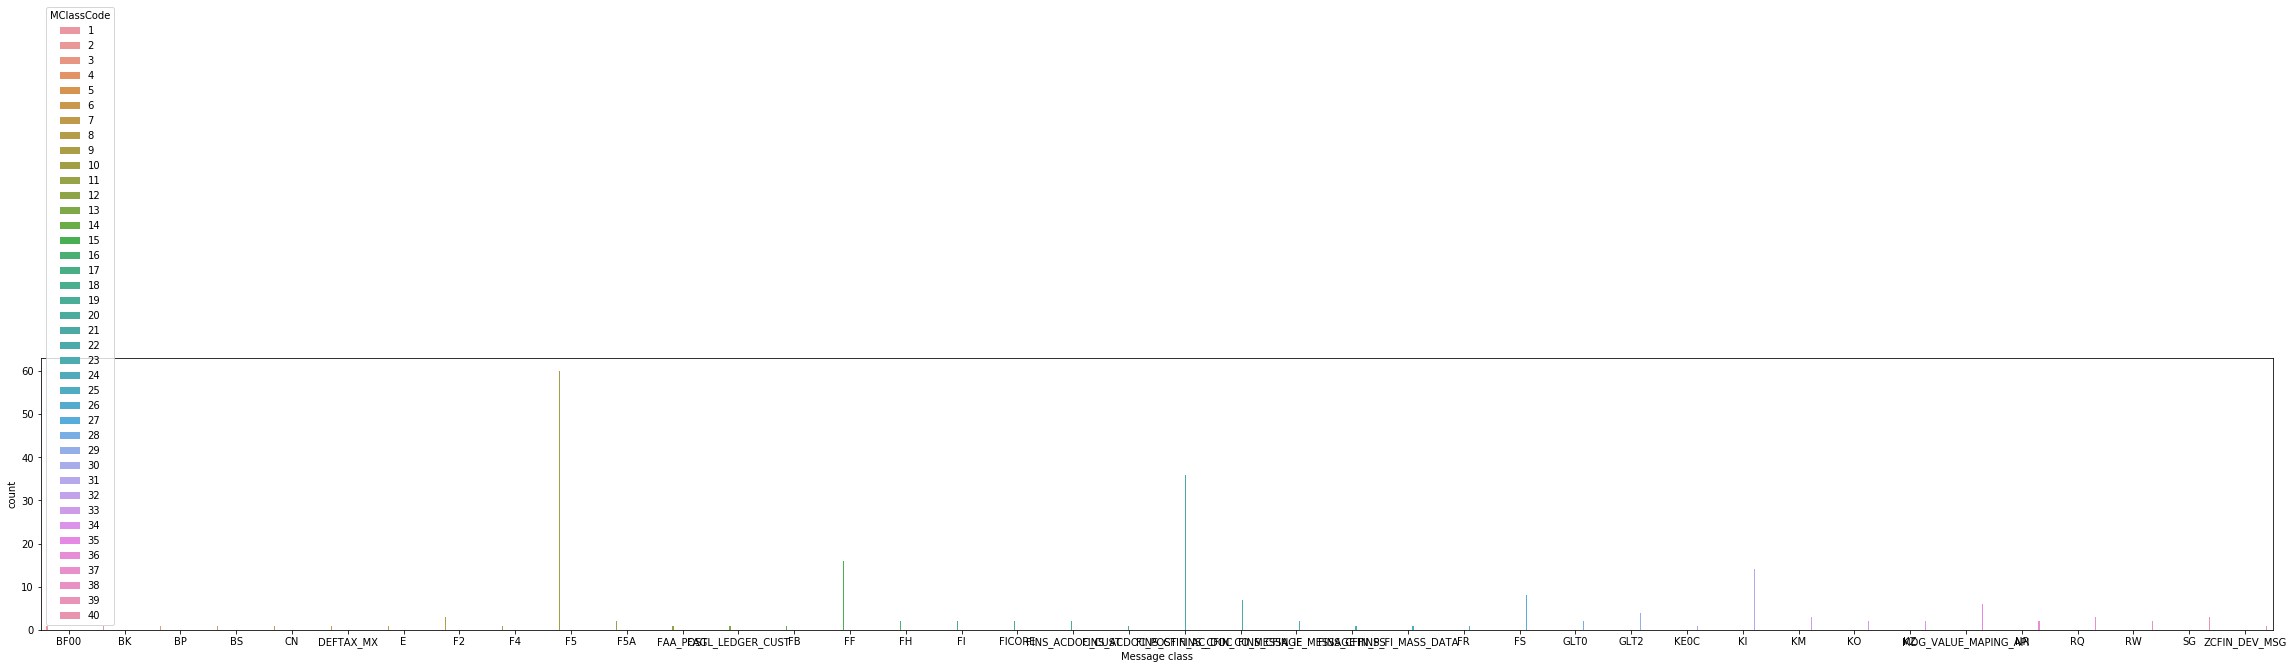

In [171]:
plt.subplots(figsize=(40,5))
sns.countplot(x='Message class',data=result,hue='MClassCode')

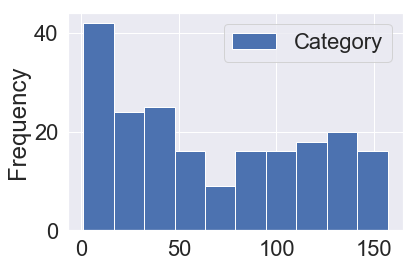

In [231]:
result.plot(kind='hist',x='Message class',y='Category')

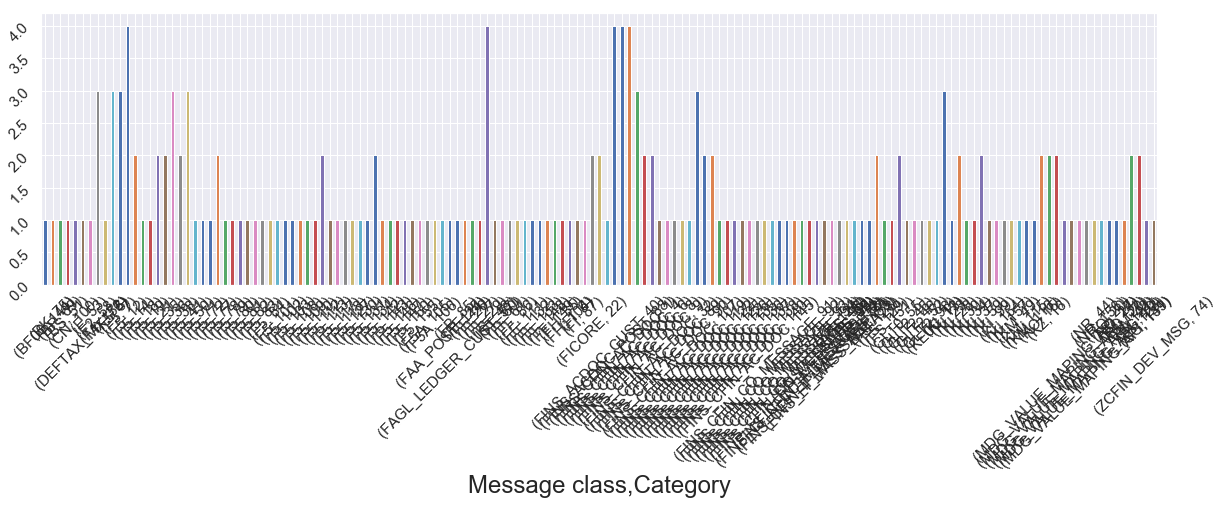

In [244]:
ax=result.groupby(['Message class','Category']).count()['Message text'].plot(kind='bar',figsize=(20,5))


ax.tick_params(axis='both', which='major', labelsize=15,labelrotation=45)

In [236]:
result.groupby(['Message class','Category']).count()

Message text  Resolution  Engie  Mars  \
Message class        Category                                          
BF00                 144                  1           1      1     1   
BK                   75                   1           1      1     1   
BP                   69                   1           1      1     1   
BS                   51                   1           1      1     1   
CN                   100                  1           1      1     1   
DEFTAX_MX            76                   1           1      1     1   
E                    53                   1           1      1     1   
F2                   58                   3           3      3     3   
F4                   152                  1           1      1     1   
F5                   5                    3           3      3     3   
                     7                    3           3      3     3   
                     12                   4           4      4     4   
                     14                   2           2      2     2   
                     18                   1           1      1     1   
                     19                   1           1      1     1   
                     21                   2           2      2     2   
                     35                   2           2      2     2   
                     36                   3           3      3     3   
                     38                   2           2      2     2   
                     41                   3           3      3     3   
                     50                   1           1      1     1   
                     71                   1           1      1     1   
                     72                   1           1      1     1   
                     77                   2           2      2     2   
                     78                   1           1      1     1   
                     79                   1           1      1     1   
                     80                   1           1      1     1   
                     81                   1           1      1     1   
                     82                   1           1      1     1   
                     83                   1           1      1     1   
                     84                   1           1      1     1   
                     101                  1           1      1     1   
                     102                  1           1      1     1   
                     103                  1           1      1     1   
                     108                  1           1      1     1   
                     109                  1           1      1     1   
                     110                  1           1      1     1   
                     112                  2           2      2     2   
                     113                  1           1      1     1   
                     117                  1           1      1     1   
                     118                  1           1      1     1   
                     127                  1           1      1     1   
                     130                  1           1      1     1   
                     131                  1           1      1     1   
                     134                  2           2      2     2   
                     142                  1           1      1     1   
                     143                  1           1      1     1   
                     146                  1           1      1     1   
                     147                  1           1      1     1   
                     150                  1           1      1     1   
                     155                  1           1      1     1   
F5A                  105                  1           1      1     1   
                     106                  1           1      1     1   
FAA_POST             114                  1           1      1     1   